In [1]:
import cx_Oracle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import zeep
import base64
from io import BytesIO
import time
from pandas.core.frame import DataFrame

In [2]:
conn = cx_Oracle.connect("ML5DI1", "ML5DI1", "10.1.100.152:1522/L5DH")
cur = conn.cursor() # 獲取操作遊標，也就是開始操作
cur.arraysize = 50 #每次取50行做儲存 (優化)
# execute a query returning the results to the cursor
print("Starting cursor at", time.ctime())

Starting cursor at Mon Nov 25 15:41:41 2019


In [3]:
#查詢資料庫
sql ="""select O.TEST_TIME,O.op_id,O.ko_id,O.abbr_no,O.lot_id, O.sheet_id,O.slot_no, O.DFT_CODE,O.pox_x, O.pox_y, O.img_file_path, E.OPER_ID,E.EQP_ID,E.UNIT_ID,E.LOGOFF_TIME,O.lm_time,O.AOI_REPAIR_FLAG\
 from\
	(select A.*,B.slot_no from
		(select to_char(test_time,'yyyy/mm/dd hh24:mi:ss') test_time,tft_lot_id lot_id, tft_sheet_id sheet_id,CURRENT_DEF_CODE_DESC DFT_CODE, substr(OP_KEY,1,4) op_id, eqp_id ko_id,
		substr(TFT_LOT_ID,1,2) abbr_no, pox_x, pox_y,'http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/' | | IMG_FILE_URL_PATH || IMAGE_FILE_NAME IMG_FILE_PATH,to_char(lm_time,'yyyy/mm/dd hh24:mi:ss') lm_time, RETYPE_REPAIR_FLAG AOI_REPAIR_FLAG
			from ARYH.H_AIDI_SECDEFECT 
			where CURRENT_DEF_CODE_DESC not in 'null' 
			and lm_time >= sysdate-1/24) A 
	join aryh.H_AIDI_SECSHEET B 
	on A.sheet_id = B.tft_sheet_id) O
 join \
 (\
	SELECT*FROM 
       		 (SELECT B.LOT_ID,B.SHEET_ID_CHIP_ID SHEET_ID,B.OP_ID OPER_ID,B.EQP_ID,B.ROUTE_ID,A.UNIT_ID,
               	 to_char(B.LOGOFF_TIME,'YYYY/MM/DD HH24:MI:SS') AS LOGOFF_TIME,
               	 RANK() OVER (PARTITION BY B.SHEET_ID_CHIP_ID,B.OP_ID ORDER BY B.LOGOFF_TIME DESC) RANK 
                   	 FROM ARYODS.H_SHEET_OPER_ODS B Left Outer Join ARYODS.H_DAX_EQPUNIT_ODS A ON  
                        B.SHEET_ID_CHIP_ID=A.SHEET_ID 
                        AND B.EQP_ID=A.EQP_ID \
                        AND SUBSTR(B.OP_ID,1,4)=SUBSTR(A.OP_ID,1,4) \
                        AND to_char(B.LOGOFF_TIME,'yyyy/mm/dd')<=to_char(A.PROCESS_TIME,'yyyy/mm/dd')  \
               ) C WHERE RANK=1 \
) E\
 on O.sheet_id = E.SHEET_ID\
 and O.test_time > E.LOGOFF_TIME\
                   """
cur.execute(sql) # 執行查詢語句 抓一個小時資料更新
print("Finished cursor at", time.ctime())
# where O.DFT_CODE='E-PV-DP Hole'\
# and O.lot_id='PW99HABC90'\

Finished cursor at Mon Nov 25 15:41:47 2019


In [5]:
spec = pd.read_excel('C:\\Users\\Andyou\\Desktop\\python_case\\Defect_spec2.xlsx',dtype={'op_id':np.str},na_values='NULL')
spec = spec.fillna('')
spec

,function,Defect_Code,op_id,主旨帶入站點,oper_id(重要站點),eqp_id,abbr_no,ko_id,mail,mail+hold,備註,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,ML5DT1,T-M1-Fiber,0100,"0000-CLA,0010-SPT","0000-CLA,0010-SPT",,,,4.0,5.0,,,,
1,ML5DT1,T-M1-Fiber,0105,"0000-CLA,0010-SPT","0000-CLA,0010-SPT",,,,4.0,5.0,,,所有站點、model放最後面，避免迴圈重複run,
2,ML5DT1,T-M1-Fiber,0025,"0000-CLA,0010-SPT","0000-CLA,0010-SPT",,,,4.0,5.0,,,,
3,ML5DT1,T-M1-Particle,0100,0010-SPT,"0010-SPT,0000-CLA",,,,0.6,1.0,,,先不卡,
4,ML5DT1,T-M1-Particle,0105,0010-SPT,"0010-SPT,0000-CLA",,,,0.6,1.0,,999,不存在,先給值
5,ML5DT1,T-M1-Particle,0205,0010-SPT,"0010-SPT,0000-CLA",,,,0.6,1.0,,,卡了但備註條件未上,
6,ML5DT1,T-M1-Residue,nan,0010-SPT,"0010-SPT,0000-CLA",,,,0.5,0.6,,,無法,
7,ML5DT1,T-Brush defect,nan,0000-CLA,"0000-CLA,0010-SPT",,,,0.8,1.0,,,,
8,ML5DT2,T-AS-M2short,nan,0200-CVD,0200-CVD,,,,1.0,1.0,,,,
9,ML5DT2,T-AS-Particle Small,0205,0200-CVD,"0200-CVD,0080-STO",,,,999.0,15.0,,,,


In [6]:
spec['oper_id(重要站點)'] = spec['oper_id(重要站點)'].str.split(',')
spec['主旨帶入站點'] = spec['主旨帶入站點'].str.split(',')

# raw data

In [7]:
rows = cur.fetchall() # 獲取查詢結果
col_result = cur.description #獲取查詢結果的欄位描述
columns = []
for i in range(len(col_result)):
    columns.append(col_result[i][0])  # 獲取欄位名，以列表形式儲存
df = pd.DataFrame(rows,columns=columns)   #轉dataframe格式
df = df.sort_values(['OPER_ID','SHEET_ID']) #按照SHEET_ID、OPER_ID數字升冪排序
pd.set_option('display.max_colwidth', -1) # 將IMG_FILE_PATH完整秀出
df.loc[:,"IMG_FILE_PATH"]='<a href="'+df[["IMG_FILE_PATH"]]+'" >'+'<img width="200" height="200" src="'+df[["IMG_FILE_PATH"]]+'" />'+'</a>' #將IMG_FILE_PATH轉為HTML格式
df.head()

,TEST_TIME,OP_ID,KO_ID,ABBR_NO,LOT_ID,SHEET_ID,SLOT_NO,DFT_CODE,POX_X,POX_Y,IMG_FILE_PATH,OPER_ID,EQP_ID,UNIT_ID,LOGOFF_TIME,LM_TIME,AOI_REPAIR_FLAG
89090,2019/11/25 13:00:34,0690,KO-08B,JH,JH99HB7J70,JH99HB7J70-17,17,T-AS-Particle Small,843822,879632,"<a href=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID102500020.JPG"" ><img width=""200"" height=""200"" src=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID102500020.JPG"" /></a>",0000_GL-CLA,WU-01B,None,2019/11/20 23:46:01,2019/11/25 15:19:28,N
89105,2019/11/25 13:00:34,0690,KO-08B,JH,JH99HB7J70,JH99HB7J70-17,17,I-Others,1138800,1051780,"<a href=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID124500012.JPG"" ><img width=""200"" height=""200"" src=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID124500012.JPG"" /></a>",0000_GL-CLA,WU-01B,None,2019/11/20 23:46:01,2019/11/25 15:19:28,N
89120,2019/11/25 13:00:34,0690,KO-08B,JH,JH99HB7J70,JH99HB7J70-17,17,I-Glass Scratch,1052880,1051370,"<a href=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID123500025.JPG"" ><img width=""200"" height=""200"" src=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID123500025.JPG"" /></a>",0000_GL-CLA,WU-01B,None,2019/11/20 23:46:01,2019/11/25 15:19:28,N
89135,2019/11/25 13:00:34,0690,KO-08B,JH,JH99HB7J70,JH99HB7J70-17,17,I-Others,999676,959426,"<a href=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID122500059.JPG"" ><img width=""200"" height=""200"" src=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID122500059.JPG"" /></a>",0000_GL-CLA,WU-01B,None,2019/11/20 23:46:01,2019/11/25 15:19:28,N
89150,2019/11/25 13:00:34,0690,KO-08B,JH,JH99HB7J70,JH99HB7J70-17,17,I-Dust,920780,993432,"<a href=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID121500044.JPG"" ><img width=""200"" height=""200"" src=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID121500044.JPG"" /></a>",0000_GL-CLA,WU-01B,None,2019/11/20 23:46:01,2019/11/25 15:19:28,N


# 計算每一批的Defect code的數量

In [8]:
DFT_Cnt = df.groupby(['LOT_ID','DFT_CODE'])['IMG_FILE_PATH'].nunique() # 使用nunique 去計算IMG_FILE_PATH避免重複計算
DFT_Cnt = pd.DataFrame(DFT_Cnt)
DFT_Cnt = DFT_Cnt.rename(columns={"IMG_FILE_PATH": "DFT_Cnt"})
print(DFT_Cnt)

                                DFT_Cnt
LOT_ID     DFT_CODE                    
JH99HB7J70 E-AS-Residue         2      
           E-M1-Al Residue      13     
           E-M2-Residue         3      
           I-Defect             4      
           I-Dust               12     
           I-Glass Scratch      10     
           I-Nothing            22     
           I-Others             186    
           I-SR_Defect          2      
           I-Sand Defect        7      
           P-M1-Residue         1      
           P-M2-Short           1      
           T-AS-Particle Small  1      
           T-Abnormal           4      
           T-M2-Fiber           5      
JH99HB7Z10 E-Abnormal           1      
           E-M1-Al Residue      4      
           E-M2-Residue         2      
           E-PV-Hole            1      
           I-Dust               8      
           I-Glass Scratch      2      
           I-Oil Like           2      
           I-Others             2      


# 計算每一批by ABBR_NO、OP_ID的Defect code的數量

In [9]:
DEFECT_COUNT_BY_ABBR_OP = df.groupby(['LOT_ID','ABBR_NO','DFT_CODE','OP_ID'])['IMG_FILE_PATH'].nunique() # 使用nunique 去計算IMG_FILE_PATH避免重複計算
DEFECT_COUNT_BY_ABBR_OP = pd.DataFrame(DEFECT_COUNT_BY_ABBR_OP)
DEFECT_COUNT_BY_ABBR_OP = DEFECT_COUNT_BY_ABBR_OP.rename(columns={"IMG_FILE_PATH": "DFT_Cnt"})
print(DEFECT_COUNT_BY_ABBR_OP)

                                              DFT_Cnt
LOT_ID     ABBR_NO DFT_CODE            OP_ID         
JH99HB7J70 JH      E-AS-Residue        0690   2      
                   E-M1-Al Residue     0690   13     
                   E-M2-Residue        0690   3      
                   I-Defect            0690   4      
                   I-Dust              0690   12     
                   I-Glass Scratch     0690   10     
                   I-Nothing           0690   22     
                   I-Others            0690   186    
                   I-SR_Defect         0690   2      
                   I-Sand Defect       0690   7      
                   P-M1-Residue        0690   1      
                   P-M2-Short          0690   1      
                   T-AS-Particle Small 0690   1      
                   T-Abnormal          0690   4      
                   T-M2-Fiber          0690   5      
JH99HB7Z10 JH      E-Abnormal          0583   1      
                   E-M1-Al R

# 計算每一片Defect code的數量

In [10]:
DEFECT_COUNT_BY_SHEET_ID = df.groupby(['LOT_ID','ABBR_NO','DFT_CODE','OP_ID','SHEET_ID'])['IMG_FILE_PATH'].nunique() # 使用nunique 去計算IMG_FILE_PATH避免重複計算
DEFECT_COUNT_BY_SHEET_ID = pd.DataFrame(DEFECT_COUNT_BY_SHEET_ID)
DEFECT_COUNT_BY_SHEET_ID = DEFECT_COUNT_BY_SHEET_ID.rename(columns={"IMG_FILE_PATH": "DFT_Cnt"})
DEFECT_COUNT_BY_SHEET_ID = DEFECT_COUNT_BY_SHEET_ID.reset_index()
print(type(DEFECT_COUNT_BY_SHEET_ID))
print(DEFECT_COUNT_BY_SHEET_ID)

<class 'pandas.core.frame.DataFrame'>
         LOT_ID ABBR_NO             DFT_CODE OP_ID       SHEET_ID  DFT_Cnt
0    JH99HB7J70  JH      E-AS-Residue         0690  JH99HB7J70-17  2      
1    JH99HB7J70  JH      E-M1-Al Residue      0690  JH99HB7J70-17  3      
2    JH99HB7J70  JH      E-M1-Al Residue      0690  JH99HB7J70-18  2      
3    JH99HB7J70  JH      E-M1-Al Residue      0690  JH99HB7J70-19  8      
4    JH99HB7J70  JH      E-M2-Residue         0690  JH99HB7J70-17  2      
5    JH99HB7J70  JH      E-M2-Residue         0690  JH99HB7J70-19  1      
6    JH99HB7J70  JH      I-Defect             0690  JH99HB7J70-17  3      
7    JH99HB7J70  JH      I-Defect             0690  JH99HB7J70-19  1      
8    JH99HB7J70  JH      I-Dust               0690  JH99HB7J70-17  5      
9    JH99HB7J70  JH      I-Dust               0690  JH99HB7J70-18  1      
10   JH99HB7J70  JH      I-Dust               0690  JH99HB7J70-19  6      
11   JH99HB7J70  JH      I-Glass Scratch      0690  JH99HB7J70

# 計算每片顆數 join 原始資料

In [11]:
df = pd.merge(df,DEFECT_COUNT_BY_SHEET_ID,on=('LOT_ID','ABBR_NO','DFT_CODE','OP_ID','SHEET_ID'),how='left')
df

,TEST_TIME,OP_ID,KO_ID,ABBR_NO,LOT_ID,SHEET_ID,SLOT_NO,DFT_CODE,POX_X,POX_Y,IMG_FILE_PATH,OPER_ID,EQP_ID,UNIT_ID,LOGOFF_TIME,LM_TIME,AOI_REPAIR_FLAG,DFT_Cnt
0,2019/11/25 13:00:34,0690,KO-08B,JH,JH99HB7J70,JH99HB7J70-17,17,T-AS-Particle Small,843822,879632,"<a href=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID102500020.JPG"" ><img width=""200"" height=""200"" src=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID102500020.JPG"" /></a>",0000_GL-CLA,WU-01B,None,2019/11/20 23:46:01,2019/11/25 15:19:28,N,1
1,2019/11/25 13:00:34,0690,KO-08B,JH,JH99HB7J70,JH99HB7J70-17,17,I-Others,1138800,1051780,"<a href=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID124500012.JPG"" ><img width=""200"" height=""200"" src=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID124500012.JPG"" /></a>",0000_GL-CLA,WU-01B,None,2019/11/20 23:46:01,2019/11/25 15:19:28,N,43
2,2019/11/25 13:00:34,0690,KO-08B,JH,JH99HB7J70,JH99HB7J70-17,17,I-Glass Scratch,1052880,1051370,"<a href=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID123500025.JPG"" ><img width=""200"" height=""200"" src=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID123500025.JPG"" /></a>",0000_GL-CLA,WU-01B,None,2019/11/20 23:46:01,2019/11/25 15:19:28,N,3
3,2019/11/25 13:00:34,0690,KO-08B,JH,JH99HB7J70,JH99HB7J70-17,17,I-Others,999676,959426,"<a href=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID122500059.JPG"" ><img width=""200"" height=""200"" src=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID122500059.JPG"" /></a>",0000_GL-CLA,WU-01B,None,2019/11/20 23:46:01,2019/11/25 15:19:28,N,43
4,2019/11/25 13:00:34,0690,KO-08B,JH,JH99HB7J70,JH99HB7J70-17,17,I-Dust,920780,993432,"<a href=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID121500044.JPG"" ><img width=""200"" height=""200"" src=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID121500044.JPG"" /></a>",0000_GL-CLA,WU-01B,None,2019/11/20 23:46:01,2019/11/25 15:19:28,N,5
5,2019/11/25 13:00:34,0690,KO-08B,JH,JH99HB7J70,JH99HB7J70-17,17,T-M2-Fiber,745231,1044730,"<a href=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID119500040.JPG"" ><img width=""200"" height=""200"" src=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID119500040.JPG"" /></a>",0000_GL-CLA,WU-01B,None,2019/11/20 23:46:01,2019/11/25 15:19:28,Y,2
6,2019/11/25 13:00:34,0690,KO-08B,JH,JH99HB7J70,JH99HB7J70-17,17,I-Others,616325,1054700,"<a href=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID117500019.JPG"" ><img width=""200"" height=""200"" src=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID117500019.JPG"" /></a>",0000_GL-CLA,WU-01B,None,2019/11/20 23:46:01,2019/11/25 15:19:28,N,43
7,2019/11/25 13:00:34,0690,KO-08B,JH,JH99HB7J70,JH99HB7J70-17,17,E-M1-Al Residue,373644,1046560,"<a href=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID114500071.JPG"" ><img width=""200"" height=""200"" src=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID114500071.JPG"" /></a>",0000_GL-CLA,WU-01B,None,2019/11/20 23:46:01,2019/11/25 15:19:28,N,3
8,2019/11/25 13:00:34,0690,KO-08B,JH,JH99HB7J70,JH99HB7J70-17,17,I-Others,171613,943713,"<a href=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID111500069.JPG"" ><img width=""200"" height=""200"" src=""http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1911/25/KO-08B/JH99HB7J70/JH99HB7J70-17/1300/NGID111500069.JPG"" /></a>",0000_GL-CLA,WU-01B,None,2019/11/20 23:46:01,2019/11/25 15:19

# 一批LOT 檢出幾片

In [12]:
SHEET = df.groupby(['ABBR_NO','LOT_ID','OP_ID','SHEET_ID']).count()
LOT_COUNT = SHEET.groupby(['LOT_ID']).count()
LOT_COUNT = LOT_COUNT.rename(columns={"DFT_CODE": "LOT_COUNT"})
LOT_COUNT = LOT_COUNT[['LOT_COUNT']]
print(LOT_COUNT) 

            LOT_COUNT
LOT_ID               
JH99HB7J70  3        
JH99HB7Z10  4        
JH99HB8700  19       
JT99HB4950  6        
JT99HB6U60  5        
JT99HB7P50  19       
LU19HB8500  6        
RV99HB2N20  19       
UU99HB1R40  19       
UU99HB5K81  6        


# 每一批的Density by Defect code

In [13]:
Density = DFT_Cnt['DFT_Cnt'] / LOT_COUNT['LOT_COUNT']
Density = round(Density,2)
Density

LOT_ID      DFT_CODE           
JH99HB7J70  E-AS-Residue           0.67 
            E-M1-Al Residue        4.33 
            E-M2-Residue           1.00 
            I-Defect               1.33 
            I-Dust                 4.00 
            I-Glass Scratch        3.33 
            I-Nothing              7.33 
            I-Others               62.00
            I-SR_Defect            0.67 
            I-Sand Defect          2.33 
            P-M1-Residue           0.33 
            P-M2-Short             0.33 
            T-AS-Particle Small    0.33 
            T-Abnormal             1.33 
            T-M2-Fiber             1.67 
JH99HB7Z10  E-Abnormal             0.25 
            E-M1-Al Residue        1.00 
            E-M2-Residue           0.50 
            E-PV-Hole              0.25 
            I-Dust                 2.00 
            I-Glass Scratch        0.50 
            I-Oil Like             0.50 
            I-Others               0.50 
            I-Sand Defect

# 每一批的Density by Defect code、ABBR_NO、OP_ID

In [14]:
Density_BY_ABBR_OP = DEFECT_COUNT_BY_ABBR_OP['DFT_Cnt'] / LOT_COUNT['LOT_COUNT']
Density_BY_ABBR_OP = round(Density_BY_ABBR_OP,2)
Density_BY_ABBR_OP

LOT_ID      ABBR_NO  DFT_CODE             OP_ID
JH99HB7J70  JH       E-AS-Residue         0690     0.67 
                     E-M1-Al Residue      0690     4.33 
                     E-M2-Residue         0690     1.00 
                     I-Defect             0690     1.33 
                     I-Dust               0690     4.00 
                     I-Glass Scratch      0690     3.33 
                     I-Nothing            0690     7.33 
                     I-Others             0690     62.00
                     I-SR_Defect          0690     0.67 
                     I-Sand Defect        0690     2.33 
                     P-M1-Residue         0690     0.33 
                     P-M2-Short           0690     0.33 
                     T-AS-Particle Small  0690     0.33 
                     T-Abnormal           0690     1.33 
                     T-M2-Fiber           0690     1.67 
JH99HB7Z10  JH       E-Abnormal           0583     0.25 
                     E-M1-Al Residue    

##  評斷是否過spec和發送mail的function

In [15]:
def judge(i,j):
    if spec['mail+hold'][i] > Density_BY_ABBR_OP[j] >= spec['mail'][i]:
        a = df[( df['LOT_ID']==Density_BY_ABBR_OP.index[j][0]) & (df['DFT_CODE']==Density_BY_ABBR_OP.index[j][2])]['SLOT_NO']
        b = []
        for k in range(len(a)):
            if a.iloc[k] not in b:   #抓出哪幾片
                b.append(a.iloc[k])
                continue
        c=b #內文片號
        if len(b)>6:
            b = '['+str(len(b))+' Sheets]'
        print(Density_BY_ABBR_OP.index[j][3]+
                '\nslot '+str(b)+' suffered '+Density_BY_ABBR_OP.index[j][2]+' issue.', 
                '\nLOT_ID: '+Density_BY_ABBR_OP.index[j][0], #LOT_ID
                '\nDEFECT_CODE: '+Density_BY_ABBR_OP.index[j][2], #DEFECT_CODE
                '\n要求確認機台狀況(mail): '+str(spec['mail'][i]),
                '\n單批異常立刻停機(mail+hold): '+str(spec['mail+hold'][i]),
                '\nDefect Qty: '+str(DFT_Cnt['DFT_Cnt'][Density_BY_ABBR_OP.index[j][0]][Density_BY_ABBR_OP.index[j][2]]), #DFT_Cnt
                '\nSheet Qty: '+str(LOT_COUNT['LOT_COUNT'][Density_BY_ABBR_OP.index[j][0]]), #LOT_COUNT
                '\nDensity: '+str(Density_BY_ABBR_OP[j])) #DENSITY
                # 抓出對應的RAW DATA     
        raw_data = df[( df['LOT_ID']==Density_BY_ABBR_OP.index[j][0]) & (df['DFT_CODE']==Density_BY_ABBR_OP.index[j][2])]
        #EQP_ID + UNIT_ID
        raw_data['UNIT_ID'] = raw_data['EQP_ID']+" "+raw_data['UNIT_ID'].fillna('') #需加入fillna('')否則無法合併
        #製程站點取前四碼+後四碼
        raw_data['OPER_ID'] = raw_data['OPER_ID'].str[:4]+raw_data['OPER_ID'].str[7:11]
        #INFORMATION
        key_oper = raw_data
        key_oper = key_oper.drop(['ABBR_NO','OP_ID','KO_ID','POX_X','POX_Y','IMG_FILE_PATH','TEST_TIME'],axis=1) 
        key_oper = key_oper.drop_duplicates()
        key_oper = key_oper.reset_index(drop=True)
        key_oper = key_oper[['LOT_ID','SHEET_ID','SLOT_NO','DFT_CODE','DFT_Cnt','OPER_ID','EQP_ID','UNIT_ID','LOGOFF_TIME']]
        #RAW_DATA
        raw_data = raw_data.drop(['ABBR_NO','OPER_ID','EQP_ID','UNIT_ID','LOGOFF_TIME'],axis=1)
        raw_data = raw_data.drop_duplicates()
        raw_data = raw_data.reset_index(drop=True)
        raw_data = raw_data[['TEST_TIME','OP_ID','KO_ID','LOT_ID','SHEET_ID','DFT_CODE','DFT_Cnt','POX_X','POX_Y','IMG_FILE_PATH','AOI_REPAIR_FLAG']]
           #濾出製程站點
        if spec['oper_id(重要站點)'][i] != '':   
            if type(spec['oper_id(重要站點)'][i]) == str:  #單一站點
                # oper title
                key_oper_title = key_oper[key_oper['OPER_ID']==spec['主旨帶入站點'][i]]
                key_oper_title = key_oper_title.reset_index(drop=True)
                ALL_TOOL = key_oper_title['UNIT_ID'].unique().tolist()
                ALL_TOOL = ",".join(ALL_TOOL)
                # oper 內文
                key_oper = key_oper[key_oper['OPER_ID']==spec['oper_id(重要站點)'][i]]
                key_oper = key_oper.reset_index(drop=True)
                    #修改站點名稱
                key_oper = key_oper.rename(columns={"UNIT_ID":key_oper['OPER_ID'].iloc[0]})
                key_oper = key_oper.drop(['EQP_ID','OPER_ID'],axis=1)
            else:   #多個站點
                # oper title
                if type(spec['主旨帶入站點'][i]) == str:
                    key_oper_title = key_oper[key_oper['OPER_ID']==spec['主旨帶入站點'][i]]
                    key_oper_title = key_oper_title.reset_index(drop=True)
                    ALL_TOOL = key_oper_title['UNIT_ID'].unique().tolist()
                    ALL_TOOL = ",".join(ALL_TOOL)
                else:
                    key_oper_title = key_oper[key_oper['OPER_ID'].isin(spec['主旨帶入站點'][i])]
                    key_oper_title = key_oper_title.reset_index(drop=True)
                    ALL_TOOL = key_oper_title['UNIT_ID'].unique().tolist()
                    ALL_TOOL = ",".join(ALL_TOOL)
                #oper 內文
                key_oper_filter = key_oper[key_oper['OPER_ID'].isin(spec['oper_id(重要站點)'][i])]
                oper_list = key_oper_filter['OPER_ID'].unique().tolist()  #帶出有的站點
                key_oper = key_oper_filter[key_oper_filter['OPER_ID']==oper_list[0]].reset_index(drop=True)       
                # 刪除"第一站"合併機台多餘欄位
                    #修改站點名稱
                key_oper = key_oper.rename(columns={"UNIT_ID":key_oper['OPER_ID'].iloc[0]})
                key_oper = key_oper.drop(['EQP_ID','OPER_ID'],axis=1)
                    #切割製程站點、機台、時間
                for a in range(len(oper_list)-1):
                    key_oper1 = key_oper_filter[key_oper_filter['OPER_ID']==oper_list[a+1]]['OPER_ID']
                    UNIT_ID = key_oper_filter[key_oper_filter['OPER_ID']==oper_list[a+1]]['UNIT_ID']
                    LOGOFF_TIME = key_oper_filter[key_oper_filter['OPER_ID']==oper_list[a+1]]['LOGOFF_TIME']
                    key_oper1 = pd.Series(key_oper1).reset_index(drop=True)
                    UNIT_ID = pd.Series(UNIT_ID).reset_index(drop=True)
                    LOGOFF_TIME = pd.Series(LOGOFF_TIME).reset_index(drop=True)
                    key_oper[key_oper1.iloc[0]]=UNIT_ID
                    key_oper['LOGOFF_TIME'+str(a+1)]=LOGOFF_TIME
                        #key_oper.insert(a+7,'LOGOFF_TIME'+str(a+1), LOGOFF_TIME)
                    #key_oper = pd.concat([key_oper,key_oper1],axis=1)
                    #key_oper['OPER_ID'+str(a+1)]=key_oper1
                    #key_oper['OPER_ID'+str(a+1)]=key_oper1[key_oper1['OPER_ID']==spec['oper_id(重要站點)'][i][a+1]].loc[:,'OPER_ID']
                    #key_oper['EQP_ID'+str(a+1)]=key_oper1[key_oper1['EQP_ID']==spec['oper_id(重要站點)'][i][a+1]].loc[:,'EQP_ID']
        elif spec['oper_id(重要站點)'][i] =='': #全部站點
            # 刪除"第一站"合併機台多餘欄位
            all_oper = key_oper['OPER_ID'].unique().tolist()
            key_oper_filter = key_oper[key_oper['OPER_ID'].isin(all_oper)]
            key_oper = key_oper[key_oper['OPER_ID']==all_oper[0]]
                #濾出所有機台
            #ALL_TOOL = key_oper_filter['UNIT_ID'].unique().tolist()
            #ALL_TOOL = ",".join(ALL_TOOL)
            ALL_TOOL=''
            key_oper = key_oper.rename(columns={"UNIT_ID":key_oper['OPER_ID'].iloc[0]})
            key_oper = key_oper.drop(['EQP_ID','OPER_ID'],axis=1)  
            #切割製程站點、機台、時間
            for a in range(len(all_oper)-1):
                key_oper1 = key_oper_filter[key_oper_filter['OPER_ID']==all_oper[a+1]]['OPER_ID']
                UNIT_ID = key_oper_filter[key_oper_filter['OPER_ID']==all_oper[a+1]]['UNIT_ID']
                LOGOFF_TIME = key_oper_filter[key_oper_filter['OPER_ID']==all_oper[a+1]]['LOGOFF_TIME']
                key_oper1 = pd.Series(key_oper1).reset_index(drop=True)
                UNIT_ID = pd.Series(UNIT_ID).reset_index(drop=True)
                LOGOFF_TIME = pd.Series(LOGOFF_TIME).reset_index(drop=True)
                key_oper[key_oper1.iloc[0]]=UNIT_ID
                #key_oper.insert(a+6,key_oper1.iloc[0], EQP_ID1)
                key_oper['LOGOFF_TIME'+str(a+1)]=LOGOFF_TIME
                #key_oper.insert(a+7,'LOGOFF_TIME'+str(a+1), LOGOFF_TIME)
        INFORMATION = key_oper.drop_duplicates()
            # defect code 照片
        picture = raw_data['IMG_FILE_PATH']
                # 散佈圖
        plt.style.use('ggplot')  #使用ggplot美化
        plt.figure(figsize=(4,3.5))
        plt.scatter(df[( df['LOT_ID']==Density_BY_ABBR_OP.index[j][0]) & (df['DFT_CODE']==Density_BY_ABBR_OP.index[j][2])].POX_X/1000,
                        df[( df['LOT_ID']==Density_BY_ABBR_OP.index[j][0]) & (df['DFT_CODE']==Density_BY_ABBR_OP.index[j][2])].POX_Y/1000)
        plt.xlim(0, 1300) #固定X axis為1300
        plt.ylim(0, 1100) #固定y axis為1100
                         # figure 儲存為二進位檔案
        buffer = BytesIO()
        plt.savefig(buffer)  
        plot_data = buffer.getvalue()
        # 圖片資料轉為 HTML 格式
        imb = base64.b64encode(plot_data)  
        ims = imb.decode()
        imd = "data:image/png;base64,"+ims
        scatter = "<h4>散佈圖"+"_"+Density_BY_ABBR_OP.index[j][2]+" & 九宮格照片</h4>"# + """<img src=\'"%s\'> """ % imd   
         # 圖片存檔 轉為Base64
        plt.savefig('C:\\Users\\Andyou\\Desktop\\AOI_scatter\\'+'散佈圖'+'_'+Density_BY_ABBR_OP.index[j][2]+'.png')
        plt.pause(0.01) #僅顯示0.01秒
        with open('C:\\Users\\Andyou\\Desktop\\AOI_scatter\\'+'散佈圖'+'_'+Density_BY_ABBR_OP.index[j][2]+'.png', "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read())
            encoded_string = encoded_string.decode('utf-8')  #去掉 b'XXXX' 
#ManualSend_39  
        if len(picture)>=9:
                    picture9=(
                     """<table border="1">
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td width="250" rowspan="3"><img src=\'"%s\'></td>
                                 </tr>
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 </tr>
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 </tr>
                                </table>""" % (picture.iloc[0],picture.iloc[1],picture.iloc[2],imd,picture.iloc[3],picture.iloc[4],
                                               picture.iloc[5],picture.iloc[6],picture.iloc[7],picture.iloc[8])
                    )
        elif len(picture)==8:
                     picture9=(
                     """<table border="1">
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td width="250" rowspan="3"><img src=\'"%s\'></td>
                                 </tr>
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 </tr>
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 </tr>
                                </table>""" % (picture.iloc[0],picture.iloc[1],picture.iloc[2],imd,picture.iloc[3],picture.iloc[4],
                                               picture.iloc[5],picture.iloc[6],picture.iloc[7])
                     )
        elif len(picture)==7:
                     picture9=(
                     """<table border="1">
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td width="250" rowspan="3"><img src=\'"%s\'></td>
                                 </tr>
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 </tr>
                                 <tr>
                                 <td>%s</td>
                                 </tr>
                                </table>""" % (picture.iloc[0],picture.iloc[1],picture.iloc[2],imd,picture.iloc[3],picture.iloc[4],
                                               picture.iloc[5],picture.iloc[6])
                     )
        elif len(picture)==6:
                     picture9=(
                     """<table border="1">
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td width="250" rowspan="2"><img src=\'"%s\'></td>
                                 </tr>
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 </tr>
                                </table>""" % (picture.iloc[0],picture.iloc[1],picture.iloc[2],imd,picture.iloc[3],picture.iloc[4],
                                               picture.iloc[5])
                     )
        elif len(picture)==5:
                     picture9=(
                     """<table border="1">
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td width="250" rowspan="2"><img src=\'"%s\'></td>
                                 </tr>
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 </tr>
                                </table>""" % (picture.iloc[0],picture.iloc[1],picture.iloc[2],imd,picture.iloc[3],picture.iloc[4]
                                               )
                     )
        elif len(picture)==4:
                     picture9=(
                     """<table border="1">
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td width="250" rowspan="2"><img src=\'"%s\'></td>
                                 </tr>
                                 <tr>
                                 <td>%s</td>
                                 </tr>
                                </table>""" % (picture.iloc[0],picture.iloc[1],picture.iloc[2],imd,picture.iloc[3]
                                               )
                     )
        elif len(picture)==3:
                     picture9=(
                     """<table border="1">
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td width="250" colspan="3"><img src=\'"%s\'></td>
                                 </tr>
                                </table>""" % (picture.iloc[0],picture.iloc[1],picture.iloc[2],imd)
                     )
        elif len(picture)==2:
                     picture9=(
                     """<table border="1">
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td width="250" colspan="2"><img src=\'"%s\'></td>
                                 </tr>
                                </table>""" % (picture.iloc[0],picture.iloc[1],imd)
                     )
        elif len(picture)==1:
                     picture9=(
                     """<table border="1">
                                 <tr>
                                 <td>%s</td>
                                 <td width="250" colspan="2"><img src=\'"%s\'></td>
                                 </tr>
                                </table>""" % (picture.iloc[0],imd)
                     )
        if Density_BY_ABBR_OP.index[j][2][:1] == 'T':
            print('T')
            ManualSend_39 = {
                        'strMailCode': 'sDM8fpGZVQ8=', #MailCode
                        'strRecipients':'andyou@auo.com', #收件人
                        'strCopyRecipients':'andyou@auo.com', #副本
                        'strSubject':'AOI'+'_'+Density_BY_ABBR_OP.index[j][3]+'_'+Density_BY_ABBR_OP.index[j][0]+'_'+str(b)+' Suffered '+Density_BY_ABBR_OP.index[j][2]+' : '+str(ALL_TOOL), #標題
                        'strBody':'<b><font color="#E00000">'+Density_BY_ABBR_OP.index[j][0]+
                        ' </font></b>'+'slot '+'<b><font color="#E00000">'+str(c)+'</font></b>'+
                        ' suffered '+'<b><font color="#E00000">'+Density_BY_ABBR_OP.index[j][2]+
                        '</font></b>'+' issue.'+'<br>'+'<br>'+ 
                        """<table border="1">
                             <tr>
                             <td bgcolor="#FFB630">要求確認機台狀況(mail)</td>
                             <td bgcolor="#FFB630"><b>%s</b></td>
                             </tr>
                             <tr>
                             <td bgcolor="#DB0000"><font color="#FFFFFF">單批異常立刻停機(mail+hold)</td>
                             <td bgcolor="#DB0000"><b><font color="#FFFFFF">%s</font></b></td>
                             </tr>
                             <tr>
                             <td>Sheet Qty</td>
                             <td>%s</td>
                             </tr>
                             <tr>
                             <td>Defect Qty</td>
                             <td>%s</td>
                             </tr>
                              <tr>
                             <td bgcolor="#00DB00"><font color="#0000D6">Density</td>
                             <td bgcolor="#00DB00"><b><font color="#0000D6">%s</b></td>
                             </tr>
                            </table>""" % (str(spec['mail'][i]),str(spec['mail+hold'][i]),
                                           str(LOT_COUNT['LOT_COUNT'][Density_BY_ABBR_OP.index[j][0]]),
                                           str(DFT_Cnt['DFT_Cnt'][Density_BY_ABBR_OP.index[j][0]][Density_BY_ABBR_OP.index[j][2]]),
                                           str(Density_BY_ABBR_OP[j]))+
                         "<h2>Information</h2>"+str(INFORMATION.to_html())+        
                        scatter+
                            str(picture9)+
                        "<h2>EDA Link</h2>"+
                '<a href="http://autceda/dashboard/sites/L5D/show/L5D_DS_TEST_Array_T1_Defect_Density_Light/PVD_KO_Density_Light?title=Density%20LIGHT&layers=160&layers=321&layers=368&">ML5DT1</a>'+
                        "<h2>Raw data(抓前50筆)</h2>"+str(raw_data[:50].to_html()), #raw data 抓前50筆 '
                        'strFileBase64String':'散佈圖'+'_'+Density_BY_ABBR_OP.index[j][2]+'.png:'+str(encoded_string) #夾檔案 需先將圖片轉base64， 格式要為: 'XXX.png' +   ':' + encoded_string
                        }
            response_39 = client.service.ManualSend_39(**ManualSend_39)
            print('是否成功發送mail: '+str(response_39))
            print()
        elif Density_BY_ABBR_OP.index[j][2][:1] == 'P':
            print('P')
            ManualSend_39 = {
                        'strMailCode': 'sDM8fpGZVQ8=', #MailCode
                        'strRecipients':'andyou@auo.com', #收件人
                        'strCopyRecipients':'andyou@auo.com', #副本
                        'strSubject':'AOI'+'_'+Density_BY_ABBR_OP.index[j][3]+'_'+Density_BY_ABBR_OP.index[j][0]+'_'+str(b)+' Suffered '+Density_BY_ABBR_OP.index[j][2]+' : '+str(ALL_TOOL), #標題
                        'strBody':'<b><font color="#E00000">'+Density_BY_ABBR_OP.index[j][0]+
                        ' </font></b>'+'slot '+'<b><font color="#E00000">'+str(c)+'</font></b>'+
                        ' suffered '+'<b><font color="#E00000">'+Density_BY_ABBR_OP.index[j][2]+
                        '</font></b>'+' issue.'+'<br>'+'<br>'+ 
                        """<table border="1">
                             <tr>
                             <td bgcolor="#FFB630">要求確認機台狀況(mail)</td>
                             <td bgcolor="#FFB630"><b>%s</b></td>
                             </tr>
                             <tr>
                             <td bgcolor="#DB0000"><font color="#FFFFFF">單批異常立刻停機(mail+hold)</td>
                             <td bgcolor="#DB0000"><b><font color="#FFFFFF">%s</font></b></td>
                             </tr>
                             <tr>
                             <td>Sheet Qty</td>
                             <td>%s</td>
                             </tr>
                             <tr>
                             <td>Defect Qty</td>
                             <td>%s</td>
                             </tr>
                              <tr>
                             <td bgcolor="#00DB00"><font color="#0000D6">Density</td>
                             <td bgcolor="#00DB00"><b><font color="#0000D6">%s</b></td>
                             </tr>
                            </table>""" % (str(spec['mail'][i]),str(spec['mail+hold'][i]),
                                           str(LOT_COUNT['LOT_COUNT'][Density_BY_ABBR_OP.index[j][0]]),
                                           str(DFT_Cnt['DFT_Cnt'][Density_BY_ABBR_OP.index[j][0]][Density_BY_ABBR_OP.index[j][2]]),
                                           str(Density_BY_ABBR_OP[j]))+
                         "<h2>Information</h2>"+str(INFORMATION.to_html())+        
                        scatter+
                            str(picture9)+
                        "<h2>EDA Link</h2>"+
                        "<h2>Raw data(抓前50筆)</h2>"+str(raw_data[:50].to_html()), #raw data 抓前50筆 '
                        'strFileBase64String':'散佈圖'+'_'+Density_BY_ABBR_OP.index[j][2]+'.png:'+str(encoded_string) #夾檔案 需先將圖片轉base64， 格式要為: 'XXX.png' +   ':' + encoded_string
                        }
            response_39 = client.service.ManualSend_39(**ManualSend_39)
            print('是否成功發送mail: '+str(response_39))
            print()
        elif Density_BY_ABBR_OP.index[j][2][:1] == 'E':
            print('E')
            ManualSend_39 = {
                        'strMailCode': 'sDM8fpGZVQ8=', #MailCode
                        'strRecipients':'andyou@auo.com', #收件人
                        'strCopyRecipients':'andyou@auo.com', #副本
                        'strSubject':'AOI'+'_'+Density_BY_ABBR_OP.index[j][3]+'_'+Density_BY_ABBR_OP.index[j][0]+'_'+str(b)+' Suffered '+Density_BY_ABBR_OP.index[j][2]+' : '+str(ALL_TOOL), #標題
                        'strBody':'<b><font color="#E00000">'+Density_BY_ABBR_OP.index[j][0]+
                        ' </font></b>'+'slot '+'<b><font color="#E00000">'+str(c)+'</font></b>'+
                        ' suffered '+'<b><font color="#E00000">'+Density_BY_ABBR_OP.index[j][2]+
                        '</font></b>'+' issue.'+'<br>'+'<br>'+ 
                        """<table border="1">
                             <tr>
                             <td bgcolor="#FFB630">要求確認機台狀況(mail)</td>
                             <td bgcolor="#FFB630"><b>%s</b></td>
                             </tr>
                             <tr>
                             <td bgcolor="#DB0000"><font color="#FFFFFF">單批異常立刻停機(mail+hold)</td>
                             <td bgcolor="#DB0000"><b><font color="#FFFFFF">%s</font></b></td>
                             </tr>
                             <tr>
                             <td>Sheet Qty</td>
                             <td>%s</td>
                             </tr>
                             <tr>
                             <td>Defect Qty</td>
                             <td>%s</td>
                             </tr>
                              <tr>
                             <td bgcolor="#00DB00"><font color="#0000D6">Density</td>
                             <td bgcolor="#00DB00"><b><font color="#0000D6">%s</b></td>
                             </tr>
                            </table>""" % (str(spec['mail'][i]),str(spec['mail+hold'][i]),
                                           str(LOT_COUNT['LOT_COUNT'][Density_BY_ABBR_OP.index[j][0]]),
                                           str(DFT_Cnt['DFT_Cnt'][Density_BY_ABBR_OP.index[j][0]][Density_BY_ABBR_OP.index[j][2]]),
                                           str(Density_BY_ABBR_OP[j]))+
                 "<h2>Information</h2>"+str(INFORMATION.to_html())+        
                scatter+
                            str(picture9)+
                        "<h2>EDA Link</h2>"+
                '<a href="http://autceda/dashboard/sites/L5D/show/L5D_DS_TEST_Array_E1_Defect_Density_Light/DRY_KO_Density_Light?title=Density_Light&layers=160&layers=321&layers=486&">ML5DE1</a>'+
                "<br>"+'<a href="http://autceda/dashboard/sites/L5D/show/L5D_DS_TEST_Array_E2_Defect_Density_Light/WET_KO_Density_Light?title=Defect_Light&layers=160&layers=321&layers=540&">ML5DE2</a>'+
                        "<h2>Raw data(抓前50筆)</h2>"+str(raw_data[:50].to_html()), #raw data 抓前50筆 '
                        'strFileBase64String':'散佈圖'+'_'+Density_BY_ABBR_OP.index[j][2]+'.png:'+str(encoded_string) #夾檔案 需先將圖片轉base64， 格式要為: 'XXX.png' +   ':' + encoded_string
                        }
            response_39 = client.service.ManualSend_39(**ManualSend_39)
            print('是否成功發送mail: '+str(response_39))
            print()
        elif Density_BY_ABBR_OP.index[j][2][:1] == 'I':
            print('I')
            ManualSend_39 = {
                        'strMailCode': 'sDM8fpGZVQ8=', #MailCode
                        'strRecipients':'andyou@auo.com', #收件人
                        'strCopyRecipients':'andyou@auo.com', #副本
                        'strSubject':'AOI'+'_'+Density_BY_ABBR_OP.index[j][3]+'_'+Density_BY_ABBR_OP.index[j][0]+'_'+str(b)+' Suffered '+Density_BY_ABBR_OP.index[j][2]+' : '+str(ALL_TOOL), #標題
                        'strBody':'<b><font color="#E00000">'+Density_BY_ABBR_OP.index[j][0]+
                        ' </font></b>'+'slot '+'<b><font color="#E00000">'+str(c)+'</font></b>'+
                        ' suffered '+'<b><font color="#E00000">'+Density_BY_ABBR_OP.index[j][2]+
                        '</font></b>'+' issue.'+'<br>'+'<br>'+ 
                        """<table border="1">
                             <tr>
                             <td bgcolor="#FFB630">要求確認機台狀況(mail)</td>
                             <td bgcolor="#FFB630"><b>%s</b></td>
                             </tr>
                             <tr>
                             <td bgcolor="#DB0000"><font color="#FFFFFF">單批異常立刻停機(mail+hold)</td>
                             <td bgcolor="#DB0000"><b><font color="#FFFFFF">%s</font></b></td>
                             </tr>
                             <tr>
                             <td>Sheet Qty</td>
                             <td>%s</td>
                             </tr>
                             <tr>
                             <td>Defect Qty</td>
                             <td>%s</td>
                             </tr>
                              <tr>
                             <td bgcolor="#00DB00"><font color="#0000D6">Density</td>
                             <td bgcolor="#00DB00"><b><font color="#0000D6">%s</b></td>
                             </tr>
                            </table>""" % (str(spec['mail'][i]),str(spec['mail+hold'][i]),
                                           str(LOT_COUNT['LOT_COUNT'][Density_BY_ABBR_OP.index[j][0]]),
                                           str(DFT_Cnt['DFT_Cnt'][Density_BY_ABBR_OP.index[j][0]][Density_BY_ABBR_OP.index[j][2]]),
                                           str(Density_BY_ABBR_OP[j]))+
                         "<h2>Information</h2>"+str(INFORMATION.to_html())+        
                        scatter+
                            str(picture9)+
                        "<h2>EDA Link</h2>"+
                '<a href="http://autceda/dashboard/sites/L5D/show/L5D_DS_TEST_Array_T1_Defect_Density_Light/PVD_KO_Density_Light?title=Density%20LIGHT&layers=160&layers=321&layers=368&">ML5DT1</a>'+
                "<br>"+
                '<a href="http://autceda/dashboard/sites/L5D/show/L5D_DS_TEST_Array_E1_Defect_Density_Light/DRY_KO_Density_Light?title=Density_Light&layers=160&layers=321&layers=486&">ML5DE1</a>'+
                "<br>"+'<a href="http://autceda/dashboard/sites/L5D/show/L5D_DS_TEST_Array_E2_Defect_Density_Light/WET_KO_Density_Light?title=Defect_Light&layers=160&layers=321&layers=540&">ML5DE2</a>'+
                        "<h2>Raw data(抓前50筆)</h2>"+str(raw_data[:50].to_html()), #raw data 抓前50筆 '
                        'strFileBase64String':'散佈圖'+'_'+Density_BY_ABBR_OP.index[j][2]+'.png:'+str(encoded_string) #夾檔案 需先將圖片轉base64， 格式要為: 'XXX.png' +   ':' + encoded_string
                        }
            response_39 = client.service.ManualSend_39(**ManualSend_39)
            print('是否成功發送mail: '+str(response_39))
            print()
    elif Density_BY_ABBR_OP[j] >= spec['mail+hold'][i]:
        a = df[( df['LOT_ID']==Density_BY_ABBR_OP.index[j][0]) & (df['DFT_CODE']==Density_BY_ABBR_OP.index[j][2])]['SLOT_NO']
        b = []
        for k in range(len(a)):
            if a.iloc[k] not in b:   #抓出哪幾片
                b.append(a.iloc[k])
                continue
        c=b #內文片號        
        if len(b)>6:
            b = '['+str(len(b))+' Sheets]'
        print(Density_BY_ABBR_OP.index[j][3]+
                '\nslot '+str(b)+' suffered '+Density_BY_ABBR_OP.index[j][2]+' issue.', 
                '\nLOT_ID: '+Density_BY_ABBR_OP.index[j][0], #LOT_ID
                '\nDEFECT_CODE: '+Density_BY_ABBR_OP.index[j][2], #DEFECT_CODE
                '\n要求確認機台狀況(mail): '+str(spec['mail'][i]),
                '\n單批異常立刻停機(mail+hold): '+str(spec['mail+hold'][i]),
                '\nDefect Qty: '+str(DFT_Cnt['DFT_Cnt'][Density_BY_ABBR_OP.index[j][0]][Density_BY_ABBR_OP.index[j][2]]), #DFT_Cnt
                '\nSheet Qty: '+str(LOT_COUNT['LOT_COUNT'][Density_BY_ABBR_OP.index[j][0]]), #LOT_COUNT
                '\nDensity: '+str(Density_BY_ABBR_OP[j])) #DENSITY
                # 抓出對應的RAW DATA      
        raw_data = df[( df['LOT_ID']==Density_BY_ABBR_OP.index[j][0]) & (df['DFT_CODE']==Density_BY_ABBR_OP.index[j][2])]
        #EQP_ID + UNIT_ID 
        raw_data['UNIT_ID'] = raw_data['EQP_ID']+" "+raw_data['UNIT_ID'].fillna('') #需加入fillna('')否則無法合併
        #製程站點取前四碼+後四碼
        raw_data['OPER_ID'] = raw_data['OPER_ID'].str[:4]+raw_data['OPER_ID'].str[7:11]
        #INFORMATION
        key_oper = raw_data
        key_oper = key_oper.drop(['ABBR_NO','OP_ID','KO_ID','POX_X','POX_Y','IMG_FILE_PATH','TEST_TIME'],axis=1) 
        key_oper = key_oper.drop_duplicates()
        key_oper = key_oper.reset_index(drop=True)
        key_oper = key_oper[['LOT_ID','SHEET_ID','SLOT_NO','DFT_CODE','DFT_Cnt','OPER_ID','EQP_ID','UNIT_ID','LOGOFF_TIME']]
        #RAW_DATA
        raw_data = raw_data.drop(['ABBR_NO','OPER_ID','EQP_ID','UNIT_ID','LOGOFF_TIME'],axis=1)
        raw_data = raw_data.drop_duplicates()
        raw_data = raw_data.reset_index(drop=True)
        raw_data = raw_data[['TEST_TIME','OP_ID','KO_ID','LOT_ID','SHEET_ID','DFT_CODE','DFT_Cnt','POX_X','POX_Y','IMG_FILE_PATH','AOI_REPAIR_FLAG']]
           #濾出製程站點
        if spec['oper_id(重要站點)'][i] != '':   
            if type(spec['oper_id(重要站點)'][i]) == str:  #單一站點
                # oper title
                key_oper_title = key_oper[key_oper['OPER_ID']==spec['主旨帶入站點'][i]]
                key_oper_title = key_oper_title.reset_index(drop=True)
                ALL_TOOL = key_oper_title['UNIT_ID'].unique().tolist()
                ALL_TOOL = ",".join(ALL_TOOL)
                # oper 內文
                key_oper = key_oper[key_oper['OPER_ID']==spec['oper_id(重要站點)'][i]]
                key_oper = key_oper.reset_index(drop=True)
                    #修改站點名稱
                key_oper = key_oper.rename(columns={"UNIT_ID":key_oper['OPER_ID'].iloc[0]})
                key_oper = key_oper.drop(['EQP_ID','OPER_ID'],axis=1)
            else:   #多個站點
                # oper title
                if type(spec['主旨帶入站點'][i]) == str:
                    key_oper_title = key_oper[key_oper['OPER_ID']==spec['主旨帶入站點'][i]]
                    key_oper_title = key_oper_title.reset_index(drop=True)
                    ALL_TOOL = key_oper_title['UNIT_ID'].unique().tolist()
                    ALL_TOOL = ",".join(ALL_TOOL)
                else:
                    key_oper_title = key_oper[key_oper['OPER_ID'].isin(spec['主旨帶入站點'][i])]
                    key_oper_title = key_oper_title.reset_index(drop=True)
                    ALL_TOOL = key_oper_title['UNIT_ID'].unique().tolist()
                    ALL_TOOL = ",".join(ALL_TOOL)
                #oper 內文
                key_oper_filter = key_oper[key_oper['OPER_ID'].isin(spec['oper_id(重要站點)'][i])]
                oper_list = key_oper_filter['OPER_ID'].unique().tolist()  #帶出有的站點
                key_oper = key_oper_filter[key_oper_filter['OPER_ID']==oper_list[0]].reset_index(drop=True)       
                # 刪除"第一站"合併機台多餘欄位
                    #修改站點名稱
                key_oper = key_oper.rename(columns={"UNIT_ID":key_oper['OPER_ID'].iloc[0]})
                key_oper = key_oper.drop(['EQP_ID','OPER_ID'],axis=1)
                    #切割製程站點、機台、時間
                for a in range(len(oper_list)-1):
                    key_oper1 = key_oper_filter[key_oper_filter['OPER_ID']==oper_list[a+1]]['OPER_ID']
                    UNIT_ID = key_oper_filter[key_oper_filter['OPER_ID']==oper_list[a+1]]['UNIT_ID']
                    LOGOFF_TIME = key_oper_filter[key_oper_filter['OPER_ID']==oper_list[a+1]]['LOGOFF_TIME']
                    key_oper1 = pd.Series(key_oper1).reset_index(drop=True)
                    UNIT_ID = pd.Series(UNIT_ID).reset_index(drop=True)
                    LOGOFF_TIME = pd.Series(LOGOFF_TIME).reset_index(drop=True)
                    key_oper[key_oper1.iloc[0]]=UNIT_ID
                    key_oper['LOGOFF_TIME'+str(a+1)]=LOGOFF_TIME
                        #key_oper.insert(a+7,'LOGOFF_TIME'+str(a+1), LOGOFF_TIME)
                    #key_oper = pd.concat([key_oper,key_oper1],axis=1)
                    #key_oper['OPER_ID'+str(a+1)]=key_oper1
                    #key_oper['OPER_ID'+str(a+1)]=key_oper1[key_oper1['OPER_ID']==spec['oper_id(重要站點)'][i][a+1]].loc[:,'OPER_ID']
                    #key_oper['EQP_ID'+str(a+1)]=key_oper1[key_oper1['EQP_ID']==spec['oper_id(重要站點)'][i][a+1]].loc[:,'EQP_ID']
        elif spec['oper_id(重要站點)'][i] =='': #全部站點
                # oper title
            if type(spec['主旨帶入站點'][i]) == str:
                key_oper_title = key_oper[key_oper['OPER_ID'].str[:4]==spec['主旨帶入站點'][i]]
                key_oper_title = key_oper_title.reset_index(drop=True)
                #ALL_TOOL = key_oper_title['UNIT_ID'].unique().tolist()
                #ALL_TOOL = ",".join(ALL_TOOL)
                ALL_TOOL=''
            else:
                key_oper_title = key_oper[key_oper['OPER_ID'].str[:4].isin(spec['主旨帶入站點'][i])]
                key_oper_title = key_oper_title.reset_index(drop=True)
                #ALL_TOOL = key_oper_title['UNIT_ID'].unique().tolist()
                #ALL_TOOL = ",".join(ALL_TOOL)
                ALL_TOOL=''
            # 刪除"第一站"合併機台多餘欄位
            all_oper = key_oper['OPER_ID'].unique().tolist()
            key_oper_filter = key_oper[key_oper['OPER_ID'].isin(all_oper)]
            key_oper = key_oper[key_oper['OPER_ID']==all_oper[0]]
                #濾出所有機台
            key_oper = key_oper.rename(columns={"UNIT_ID":key_oper['OPER_ID'].iloc[0]})
            key_oper = key_oper.drop(['EQP_ID','OPER_ID'],axis=1)  
            #切割製程站點、機台、時間
            for a in range(len(all_oper)-1):
                key_oper1 = key_oper_filter[key_oper_filter['OPER_ID']==all_oper[a+1]]['OPER_ID']
                UNIT_ID = key_oper_filter[key_oper_filter['OPER_ID']==all_oper[a+1]]['UNIT_ID']
                LOGOFF_TIME = key_oper_filter[key_oper_filter['OPER_ID']==all_oper[a+1]]['LOGOFF_TIME']
                key_oper1 = pd.Series(key_oper1).reset_index(drop=True)
                UNIT_ID = pd.Series(UNIT_ID).reset_index(drop=True)
                LOGOFF_TIME = pd.Series(LOGOFF_TIME).reset_index(drop=True)
                key_oper[key_oper1.iloc[0]]=UNIT_ID
                #key_oper.insert(a+6,key_oper1.iloc[0], EQP_ID1)
                key_oper['LOGOFF_TIME'+str(a+1)]=LOGOFF_TIME
                #key_oper.insert(a+7,'LOGOFF_TIME'+str(a+1), LOGOFF_TIME)
        #抓出對應的資訊
        INFORMATION = key_oper.drop_duplicates()
            # defect code 照片
        picture = raw_data['IMG_FILE_PATH']
                # 散佈圖
        plt.style.use('ggplot')  #使用ggplot美化
        plt.figure(figsize=(4,3.5))
        plt.scatter(df[( df['LOT_ID']==Density_BY_ABBR_OP.index[j][0]) & (df['DFT_CODE']==Density_BY_ABBR_OP.index[j][2])].POX_X/1000,
                        df[( df['LOT_ID']==Density_BY_ABBR_OP.index[j][0]) & (df['DFT_CODE']==Density_BY_ABBR_OP.index[j][2])].POX_Y/1000)
        plt.xlim(0, 1300) #固定X axis為1300
        plt.ylim(0, 1100) #固定y axis為1100
                         # figure 儲存為二進位檔案
        buffer = BytesIO()
        plt.savefig(buffer)  
        plot_data = buffer.getvalue()

        # 圖片資料轉為 HTML 格式
        imb = base64.b64encode(plot_data)  
        ims = imb.decode()
        imd = "data:image/png;base64,"+ims
        scatter = "<h4>散佈圖"+"_"+Density_BY_ABBR_OP.index[j][2]+" & 九宮格照片</h4>" #+ """<img src=\'"%s\'> """ % imd   
         # 圖片存檔 轉為Base64
        plt.savefig('C:\\Users\\Andyou\\Desktop\\AOI_scatter\\'+'散佈圖'+'_'+Density_BY_ABBR_OP.index[j][2]+'.png')
        plt.pause(0.01) #僅顯示0.01秒
        with open('C:\\Users\\Andyou\\Desktop\\AOI_scatter\\'+'散佈圖'+'_'+Density_BY_ABBR_OP.index[j][2]+'.png', "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read())
            encoded_string = encoded_string.decode('utf-8')  #去掉 b'XXXX' 
#ManualSend_39  
        if len(picture)>=9:
                    picture9=(
                     """<table border="1">
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td width="250" rowspan="3"><img src=\'"%s\'></td>
                                 </tr>
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 </tr>
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 </tr>
                                </table>""" % (picture.iloc[0],picture.iloc[1],picture.iloc[2],imd,picture.iloc[3],picture.iloc[4],
                                               picture.iloc[5],picture.iloc[6],picture.iloc[7],picture.iloc[8])
                    )
        elif len(picture)==8:
                     picture9=(
                     """<table border="1">
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td width="250" rowspan="3"><img src=\'"%s\'></td>
                                 </tr>
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 </tr>
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 </tr>
                                </table>""" % (picture.iloc[0],picture.iloc[1],picture.iloc[2],imd,picture.iloc[3],picture.iloc[4],
                                               picture.iloc[5],picture.iloc[6],picture.iloc[7])
                     )
        elif len(picture)==7:
                     picture9=(
                     """<table border="1">
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td width="250" rowspan="3"><img src=\'"%s\'></td>
                                 </tr>
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 </tr>
                                 <tr>
                                 <td>%s</td>
                                 </tr>
                                </table>""" % (picture.iloc[0],picture.iloc[1],picture.iloc[2],imd,picture.iloc[3],picture.iloc[4],
                                               picture.iloc[5],picture.iloc[6])
                     )
        elif len(picture)==6:
                     picture9=(
                     """<table border="1">
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td width="250" rowspan="2"><img src=\'"%s\'></td>
                                 </tr>
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 </tr>
                                </table>""" % (picture.iloc[0],picture.iloc[1],picture.iloc[2],imd,picture.iloc[3],picture.iloc[4],
                                               picture.iloc[5])
                     )
        elif len(picture)==5:
                     picture9=(
                     """<table border="1">
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td width="250" rowspan="2"><img src=\'"%s\'></td>
                                 </tr>
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 </tr>
                                </table>""" % (picture.iloc[0],picture.iloc[1],picture.iloc[2],imd,picture.iloc[3],picture.iloc[4]
                                               )
                     )
        elif len(picture)==4:
                     picture9=(
                     """<table border="1">
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td width="250" rowspan="2"><img src=\'"%s\'></td>
                                 </tr>
                                 <tr>
                                 <td>%s</td>
                                 </tr>
                                </table>""" % (picture.iloc[0],picture.iloc[1],picture.iloc[2],imd,picture.iloc[3]
                                               )
                     )
        elif len(picture)==3:
                     picture9=(
                     """<table border="1">
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td width="250" colspan="3"><img src=\'"%s\'></td>
                                 </tr>
                                </table>""" % (picture.iloc[0],picture.iloc[1],picture.iloc[2],imd)
                     )
        elif len(picture)==2:
                     picture9=(
                     """<table border="1">
                                 <tr>
                                 <td>%s</td>
                                 <td>%s</td>
                                 <td width="250" colspan="2"><img src=\'"%s\'></td>
                                 </tr>
                                </table>""" % (picture.iloc[0],picture.iloc[1],imd)
                     )
        elif len(picture)==1:
                     picture9=(
                     """<table border="1">
                                 <tr>
                                 <td>%s</td>
                                 <td width="250" colspan="2"><img src=\'"%s\'></td>
                                 </tr>
                                </table>""" % (picture.iloc[0],imd)
                     )
        if Density_BY_ABBR_OP.index[j][2][:1] == 'T':
            print('T & MFG')
            ManualSend_39 = {
                        'strMailCode': 'sDM8fpGZVQ8=', #MailCode
                        'strRecipients':'andyou@auo.com', #收件人
                        'strCopyRecipients':'andyou@auo.com', #副本
                        'strSubject':'AOI'+'_'+Density_BY_ABBR_OP.index[j][3]+'_'+Density_BY_ABBR_OP.index[j][0]+'_'+str(b)+' Suffered '+Density_BY_ABBR_OP.index[j][2]+' : '+str(ALL_TOOL)+' (單批異常立刻停機)', #標題
                        'strBody':'<b><font color="#E00000">'+Density_BY_ABBR_OP.index[j][0]+
                        ' </font></b>'+'slot '+'<b><font color="#E00000">'+str(c)+'</font></b>'+
                        ' suffered '+'<b><font color="#E00000">'+Density_BY_ABBR_OP.index[j][2]+
                        '</font></b>'+' issue.'+'<br>'+'<br>'+ 
                        """<table border="1">
                             <tr>
                             <td bgcolor="#FFB630">要求確認機台狀況(mail)</td>
                             <td bgcolor="#FFB630"><b>%s</b></td>
                             </tr>
                             <tr>
                             <td bgcolor="#DB0000"><font color="#FFFFFF">單批異常立刻停機(mail+hold)</td>
                             <td bgcolor="#DB0000"><b><font color="#FFFFFF">%s</font></b></td>
                             </tr>
                             <tr>
                             <td>Sheet Qty</td>
                             <td>%s</td>
                             </tr>
                             <tr>
                             <td>Defect Qty</td>
                             <td>%s</td>
                             </tr>
                              <tr>
                             <td bgcolor="#00DB00"><font color="#0000D6">Density</td>
                             <td bgcolor="#00DB00"><b><font color="#0000D6">%s</b></td>
                             </tr>
                            </table>""" % (str(spec['mail'][i]),str(spec['mail+hold'][i]),
                                           str(LOT_COUNT['LOT_COUNT'][Density_BY_ABBR_OP.index[j][0]]),
                                           str(DFT_Cnt['DFT_Cnt'][Density_BY_ABBR_OP.index[j][0]][Density_BY_ABBR_OP.index[j][2]]),
                                           str(Density_BY_ABBR_OP[j]))+
                         "<h2>Information</h2>"+str(INFORMATION.to_html())+        
                        scatter+
                            str(picture9)+
                        "<h2>EDA Link</h2>"+
                '<a href="http://autceda/dashboard/sites/L5D/show/L5D_DS_TEST_Array_T1_Defect_Density_Light/PVD_KO_Density_Light?title=Density%20LIGHT&layers=160&layers=321&layers=368&">ML5DT1</a>'+
                        "<h2>Raw data(抓前50筆)</h2>"+str(raw_data[:50].to_html()), #raw data 抓前50筆 '
                        'strFileBase64String':'散佈圖'+'_'+Density_BY_ABBR_OP.index[j][2]+'.png:'+str(encoded_string) #夾檔案 需先將圖片轉base64， 格式要為: 'XXX.png' +   ':' + encoded_string
                        }
            response_39 = client.service.ManualSend_39(**ManualSend_39)
            print('是否成功發送mail: '+str(response_39))
            print()
        elif Density_BY_ABBR_OP.index[j][2][:1] == 'P':
            print('P & MFG')
            ManualSend_39 = {
                        'strMailCode': 'sDM8fpGZVQ8=', #MailCode
                        'strRecipients':'andyou@auo.com', #收件人
                        'strCopyRecipients':'andyou@auo.com', #副本
                        'strSubject':'AOI'+'_'+Density_BY_ABBR_OP.index[j][3]+'_'+Density_BY_ABBR_OP.index[j][0]+'_'+str(b)+' Suffered '+Density_BY_ABBR_OP.index[j][2]+' : '+str(ALL_TOOL)+' (單批異常立刻停機)', #標題
                        'strBody':'<b><font color="#E00000">'+Density_BY_ABBR_OP.index[j][0]+
                        ' </font></b>'+'slot '+'<b><font color="#E00000">'+str(c)+'</font></b>'+
                        ' suffered '+'<b><font color="#E00000">'+Density_BY_ABBR_OP.index[j][2]+
                        '</font></b>'+' issue.'+'<br>'+'<br>'+ 
                        """<table border="1">
                             <tr>
                             <td bgcolor="#FFB630">要求確認機台狀況(mail)</td>
                             <td bgcolor="#FFB630"><b>%s</b></td>
                             </tr>
                             <tr>
                             <td bgcolor="#DB0000"><font color="#FFFFFF">單批異常立刻停機(mail+hold)</td>
                             <td bgcolor="#DB0000"><b><font color="#FFFFFF">%s</font></b></td>
                             </tr>
                             <tr>
                             <td>Sheet Qty</td>
                             <td>%s</td>
                             </tr>
                             <tr>
                             <td>Defect Qty</td>
                             <td>%s</td>
                             </tr>
                              <tr>
                             <td bgcolor="#00DB00"><font color="#0000D6">Density</td>
                             <td bgcolor="#00DB00"><b><font color="#0000D6">%s</b></td>
                             </tr>
                            </table>""" % (str(spec['mail'][i]),str(spec['mail+hold'][i]),
                                           str(LOT_COUNT['LOT_COUNT'][Density_BY_ABBR_OP.index[j][0]]),
                                           str(DFT_Cnt['DFT_Cnt'][Density_BY_ABBR_OP.index[j][0]][Density_BY_ABBR_OP.index[j][2]]),
                                           str(Density_BY_ABBR_OP[j]))+
                         "<h2>Information</h2>"+str(INFORMATION.to_html())+        
                        scatter+
                            str(picture9)+
                        "<h2>EDA Link</h2>"+
                        "<h2>Raw data(抓前50筆)</h2>"+str(raw_data[:50].to_html()), #raw data 抓前50筆 '
                        'strFileBase64String':'散佈圖'+'_'+Density_BY_ABBR_OP.index[j][2]+'.png:'+str(encoded_string) #夾檔案 需先將圖片轉base64， 格式要為: 'XXX.png' +   ':' + encoded_string
                        }
            response_39 = client.service.ManualSend_39(**ManualSend_39)
            print('是否成功發送mail: '+str(response_39))
            print()
        elif Density_BY_ABBR_OP.index[j][2][:1] == 'E':
            print('E & MFG')
            ManualSend_39 = {
                        'strMailCode': 'sDM8fpGZVQ8=', #MailCode
                        'strRecipients':'andyou@auo.com', #收件人
                        'strCopyRecipients':'andyou@auo.com', #副本
                        'strSubject':'AOI'+'_'+Density_BY_ABBR_OP.index[j][3]+'_'+Density_BY_ABBR_OP.index[j][0]+'_'+str(b)+' Suffered '+Density_BY_ABBR_OP.index[j][2]+' : '+str(ALL_TOOL)+' (單批異常立刻停機)', #標題
                        'strBody':'<b><font color="#E00000">'+Density_BY_ABBR_OP.index[j][0]+
                        ' </font></b>'+'slot '+'<b><font color="#E00000">'+str(c)+'</font></b>'+
                        ' suffered '+'<b><font color="#E00000">'+Density_BY_ABBR_OP.index[j][2]+
                        '</font></b>'+' issue.'+'<br>'+'<br>'+ 
                        """<table border="1">
                             <tr>
                             <td bgcolor="#FFB630">要求確認機台狀況(mail)</td>
                             <td bgcolor="#FFB630"><b>%s</b></td>
                             </tr>
                             <tr>
                             <td bgcolor="#DB0000"><font color="#FFFFFF">單批異常立刻停機(mail+hold)</td>
                             <td bgcolor="#DB0000"><b><font color="#FFFFFF">%s</font></b></td>
                             </tr>
                             <tr>
                             <td>Sheet Qty</td>
                             <td>%s</td>
                             </tr>
                             <tr>
                             <td>Defect Qty</td>
                             <td>%s</td>
                             </tr>
                              <tr>
                             <td bgcolor="#00DB00"><font color="#0000D6">Density</td>
                             <td bgcolor="#00DB00"><b><font color="#0000D6">%s</b></td>
                             </tr>
                            </table>""" % (str(spec['mail'][i]),str(spec['mail+hold'][i]),
                                           str(LOT_COUNT['LOT_COUNT'][Density_BY_ABBR_OP.index[j][0]]),
                                           str(DFT_Cnt['DFT_Cnt'][Density_BY_ABBR_OP.index[j][0]][Density_BY_ABBR_OP.index[j][2]]),
                                           str(Density_BY_ABBR_OP[j]))+
                         "<h2>Information</h2>"+str(INFORMATION.to_html())+        
                        scatter+
                            str(picture9)+
                        "<h2>EDA Link</h2>"+
                '<a href="http://autceda/dashboard/sites/L5D/show/L5D_DS_TEST_Array_E1_Defect_Density_Light/DRY_KO_Density_Light?title=Density_Light&layers=160&layers=321&layers=486&">ML5DE1</a>'+
                "<br>"+'<a href="http://autceda/dashboard/sites/L5D/show/L5D_DS_TEST_Array_E2_Defect_Density_Light/WET_KO_Density_Light?title=Defect_Light&layers=160&layers=321&layers=540&">ML5DE2</a>'+
                        "<h2>Raw data(抓前50筆)</h2>"+str(raw_data[:50].to_html()), #raw data 抓前50筆 '
                        'strFileBase64String':'散佈圖'+'_'+Density_BY_ABBR_OP.index[j][2]+'.png:'+str(encoded_string) #夾檔案 需先將圖片轉base64， 格式要為: 'XXX.png' +   ':' + encoded_string
                        }
            response_39 = client.service.ManualSend_39(**ManualSend_39)
            print('是否成功發送mail: '+str(response_39))
            print()
        elif Density_BY_ABBR_OP.index[j][2][:1] == 'I':
            print('I & MFG')
            ManualSend_39 = {
                        'strMailCode': 'sDM8fpGZVQ8=', #MailCode
                        'strRecipients':'andyou@auo.com', #收件人
                        'strCopyRecipients':'andyou@auo.com', #副本
                        'strSubject':'AOI'+'_'+Density_BY_ABBR_OP.index[j][3]+'_'+Density_BY_ABBR_OP.index[j][0]+'_'+str(b)+' Suffered '+Density_BY_ABBR_OP.index[j][2]+' : '+str(ALL_TOOL)+' (單批異常立刻停機)', #標題
                        'strBody':'<b><font color="#E00000">'+Density_BY_ABBR_OP.index[j][0]+
                        ' </font></b>'+'slot '+'<b><font color="#E00000">'+str(c)+'</font></b>'+
                        ' suffered '+'<b><font color="#E00000">'+Density_BY_ABBR_OP.index[j][2]+
                        '</font></b>'+' issue.'+'<br>'+'<br>'+ 
                        """<table border="1">
                             <tr>
                             <td bgcolor="#FFB630">要求確認機台狀況(mail)</td>
                             <td bgcolor="#FFB630"><b>%s</b></td>
                             </tr>
                             <tr>
                             <td bgcolor="#DB0000"><font color="#FFFFFF">單批異常立刻停機(mail+hold)</td>
                             <td bgcolor="#DB0000"><b><font color="#FFFFFF">%s</font></b></td>
                             </tr>
                             <tr>
                             <td>Sheet Qty</td>
                             <td>%s</td>
                             </tr>
                             <tr>
                             <td>Defect Qty</td>
                             <td>%s</td>
                             </tr>
                              <tr>
                             <td bgcolor="#00DB00"><font color="#0000D6">Density</td>
                             <td bgcolor="#00DB00"><b><font color="#0000D6">%s</b></td>
                             </tr>
                            </table>""" % (str(spec['mail'][i]),str(spec['mail+hold'][i]),
                                           str(LOT_COUNT['LOT_COUNT'][Density_BY_ABBR_OP.index[j][0]]),
                                           str(DFT_Cnt['DFT_Cnt'][Density_BY_ABBR_OP.index[j][0]][Density_BY_ABBR_OP.index[j][2]]),
                                           str(Density_BY_ABBR_OP[j]))+
                         "<h2>Information</h2>"+str(INFORMATION.to_html())+        
                        scatter+
                            str(picture9)+
                        "<h2>EDA Link</h2>"+
                '<a href="http://autceda/dashboard/sites/L5D/show/L5D_DS_TEST_Array_T1_Defect_Density_Light/PVD_KO_Density_Light?title=Density%20LIGHT&layers=160&layers=321&layers=368&">ML5DT1</a>'+
                "<br>"+
                '<a href="http://autceda/dashboard/sites/L5D/show/L5D_DS_TEST_Array_E1_Defect_Density_Light/DRY_KO_Density_Light?title=Density_Light&layers=160&layers=321&layers=486&">ML5DE1</a>'+
                "<br>"+'<a href="http://autceda/dashboard/sites/L5D/show/L5D_DS_TEST_Array_E2_Defect_Density_Light/WET_KO_Density_Light?title=Defect_Light&layers=160&layers=321&layers=540&">ML5DE2</a>'+
                        "<h2>Raw data(抓前50筆)</h2>"+str(raw_data[:50].to_html()), #raw data 抓前50筆 '
                        'strFileBase64String':'散佈圖'+'_'+Density_BY_ABBR_OP.index[j][2]+'.png:'+str(encoded_string) #夾檔案 需先將圖片轉base64， 格式要為: 'XXX.png' +   ':' + encoded_string
                        }
            response_39 = client.service.ManualSend_39(**ManualSend_39)
            print('是否成功發送mail: '+str(response_39))
            print()
    return

# Density by Defect code，卡spec，過標才抓出來

no op_id & but model ('JH99HB7J70', 'JH', 'E-AS-Residue', '0690') E-AS-Residue nan ['0240-RIE', '0210-IEX'] JH
0 91 E-AS-Residue E-AS-Residue
nothing ('JH99HB7J70', 'JH', 'E-M1-Al Residue', '0690') E-M1-Al Residue nan ['0030-IEX', '0060-WMO']
1 86 E-M1-Al Residue E-M1-Al Residue
nothing ('JH99HB7J70', 'JH', 'E-M2-Residue', '0690') E-M2-Residue nan ['0650-RIE', '0640-WMO']
2 104 E-M2-Residue E-M2-Residue
nothing ('JH99HB7J70', 'JH', 'P-M1-Residue', '0690') P-M1-Residue nan ['0030-IEX']
10 55 P-M1-Residue P-M1-Residue
nothing ('JH99HB7J70', 'JH', 'P-M2-Short', '0690') P-M2-Short nan ['0610-IEX']
11 63 P-M2-Short P-M2-Short
op_id but no model ('JH99HB7J70', 'JH', 'T-AS-Particle Small', '0690') T-AS-Particle Small 0690 ['0200-CVD', '0080-STO'] 
12 10 T-AS-Particle Small T-AS-Particle Small
no op_id & but model ('JH99HB7J70', 'JH', 'T-M2-Fiber', '0690') T-M2-Fiber nan ['0600-SPT', '0210-IEX', '0670-STO'] JH
14 22 T-M2-Fiber T-M2-Fiber
nothing ('JH99HB7Z10', 'JH', 'E-M1-Al Residue', '0583') 

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:490: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:492: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


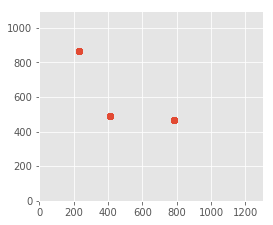

P & MFG
是否成功發送mail: True

nothing ('JT99HB4950', 'JT', 'T-AS-Residue', '0513') T-AS-Residue nan ['0200-CVD']
66 14 T-AS-Residue T-AS-Residue
no op_id & but model ('JT99HB4950', 'JT', 'T-M2-Fiber', '0513') T-M2-Fiber nan ['0600-SPT', '0210-IEX', '0670-STO'] JT
67 20 T-M2-Fiber T-M2-Fiber
nothing ('JT99HB4950', 'JT', 'T-M2-Residue', '0513') T-M2-Residue nan ['0600-SPT']
68 30 T-M2-Residue T-M2-Residue
nothing ('JT99HB4950', 'JT', 'T-PV-Hole', '0513') T-PV-Hole nan ['0510-CVD', '0800-CVD']
69 42 T-PV-Hole T-PV-Hole
nothing ('JT99HB4950', 'JT', 'T-PV-Residue', '0513') T-PV-Residue nan ['0800-CVD', '0510-CVD', '0760-WZO', '0697-CLA', '0797-CLA', '0810-CLA']
70 45 T-PV-Residue T-PV-Residue
no op_id & but model ('JT99HB6U60', 'JT', 'E-AS-Residue', '0690') E-AS-Residue nan ['0240-RIE', '0210-IEX'] JT
71 89 E-AS-Residue E-AS-Residue
nothing ('JT99HB6U60', 'JT', 'E-M1-Al Residue', '0690') E-M1-Al Residue nan ['0030-IEX', '0060-WMO']
72 86 E-M1-Al Residue E-M1-Al Residue
nothing ('JT99HB6U60', 'J

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


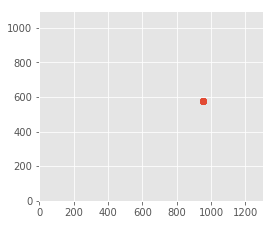

P
是否成功發送mail: True

nothing ('JT99HB6U60', 'JT', 'P-M2-Open', '0690') P-M2-Open nan ['0610-IEX']
85 61 P-M2-Open P-M2-Open
op_id but no model ('JT99HB6U60', 'JT', 'T-AS-Residue', '0690') T-AS-Residue 0690 ['0200-CVD'] 
86 13 T-AS-Residue T-AS-Residue
no op_id & but model ('JT99HB6U60', 'JT', 'T-M2-Fiber', '0690') T-M2-Fiber nan ['0600-SPT', '0210-IEX', '0670-STO'] JT
88 20 T-M2-Fiber T-M2-Fiber
nothing ('JT99HB6U60', 'JT', 'T-M2-Residue', '0690') T-M2-Residue nan ['0600-SPT']
89 30 T-M2-Residue T-M2-Residue
nothing ('JT99HB7P50', 'JT', 'E-AS-BPADJ', '0690') E-AS-BPADJ nan ['0240-RIE', '0210-IEX']
90 93 E-AS-BPADJ E-AS-BPADJ
no op_id & but model ('JT99HB7P50', 'JT', 'E-AS-Residue', '0690') E-AS-Residue nan ['0240-RIE', '0210-IEX'] JT
91 89 E-AS-Residue E-AS-Residue
nothing ('JT99HB7P50', 'JT', 'E-M1-Al Residue', '0690') E-M1-Al Residue nan ['0030-IEX', '0060-WMO']
93 86 E-M1-Al Residue E-M1-Al Residue
nothing ('JT99HB7P50', 'JT', 'E-M2-Residue', '0690') E-M2-Residue nan ['0650-RIE', '06

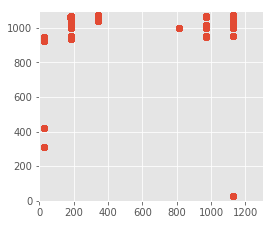

T & MFG
是否成功發送mail: True

nothing ('JT99HB7P50', 'JT', 'T-M2-Residue', '0690') T-M2-Residue nan ['0600-SPT']
116 30 T-M2-Residue T-M2-Residue
op_id but no model ('LU19HB8500', 'LU', 'E-M1-Al Residue', '0105') E-M1-Al Residue 0105 ['0030-IEX', '0060-WMO'] 
117 85 E-M1-Al Residue E-M1-Al Residue
0105
slot [1, 2, 3, 4, 5, 6] suffered E-M1-Al Residue issue. 
LOT_ID: LU19HB8500 
DEFECT_CODE: E-M1-Al Residue 
要求確認機台狀況(mail): 5.0 
單批異常立刻停機(mail+hold): 10.0 
Defect Qty: 44 
Sheet Qty: 6 
Density: 7.33


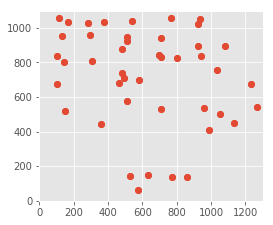

E
是否成功發送mail: True

nothing ('LU19HB8500', 'LU', 'E-PV-DP Hole', '0105') E-PV-DP Hole nan ['0860-RIE', '0560-RIE']
118 112 E-PV-DP Hole E-PV-DP Hole
nothing ('LU19HB8500', 'LU', 'I-M2-Open', '0105') I-M2-Open nan ['0600-SPT', '0250-STO', '0610-IEX']
122 138 I-M2-Open I-M2-Open
0105
slot [2, 4] suffered I-M2-Open issue. 
LOT_ID: LU19HB8500 
DEFECT_CODE: I-M2-Open 
要求確認機台狀況(mail): 0.26 
單批異常立刻停機(mail+hold): 999.0 
Defect Qty: 14 
Sheet Qty: 6 
Density: 2.33


IndexError: list index out of range

In [16]:
client = zeep.Client("http://ids.cdn.corpnet.auo.com/IDS_WS/Mail.asmx?wsdl") #連結IDS

for j in range(len(Density_BY_ABBR_OP)):
    for i in range(len(spec['Defect_Code'])):  
        if (Density_BY_ABBR_OP.index[j][2] == spec['Defect_Code'][i]) &  (spec['op_id'][i]=="nan" ) & (Density_BY_ABBR_OP.index[j][1] == spec['abbr_no'][i]): #沒有對到站點，有對到model(針對model類型)
                    print("no op_id & but model",Density_BY_ABBR_OP.index[j],spec['Defect_Code'][i],spec['op_id'][i],spec['oper_id(重要站點)'][i],spec['abbr_no'][i])
                    print(j,i,Density_BY_ABBR_OP.index[j][2],spec['Defect_Code'][i])
                    judge(i,j)
                    break
        elif (Density_BY_ABBR_OP.index[j][2] == spec['Defect_Code'][i]) & (Density_BY_ABBR_OP.index[j][3] == spec['op_id'][i]) & (spec['abbr_no'][i]=="" ): #有對到站點，沒對到model(針對站點類型)
                    print("op_id but no model",Density_BY_ABBR_OP.index[j],spec['Defect_Code'][i],spec['op_id'][i],spec['oper_id(重要站點)'][i],spec['abbr_no'][i])
                    print(j,i,Density_BY_ABBR_OP.index[j][2],spec['Defect_Code'][i])
                    judge(i,j)
                    break
        elif (Density_BY_ABBR_OP.index[j][2] == spec['Defect_Code'][i]) & (Density_BY_ABBR_OP.index[j][3] == spec['op_id'][i]) & (Density_BY_ABBR_OP.index[j][1] == spec['abbr_no'][i]): #有對到站點，有對到model(針對model+站點類型)
                    print("op_id & model",Density_BY_ABBR_OP.index[j],spec['Defect_Code'][i],spec['op_id'][i],spec['oper_id(重要站點)'][i],spec['abbr_no'][i])
                    print(j,i,Density_BY_ABBR_OP.index[j][2],spec['Defect_Code'][i])
                    judge(i,j)
                    break
        elif (Density_BY_ABBR_OP.index[j][2] == spec['Defect_Code'][i]) & (spec['op_id'][i]=="nan") & (spec['abbr_no'][i]==""):  #沒有對到站點和model(一般類型)
                    print("nothing",Density_BY_ABBR_OP.index[j],spec['Defect_Code'][i],spec['op_id'][i],spec['oper_id(重要站點)'][i])
                    print(j,i,Density_BY_ABBR_OP.index[j][2],spec['Defect_Code'][i])
                    judge(i,j)
                    break

In [26]:
print(len(spec[0]),len(spec[1]),len(spec[2]),len(spec[3]),len(spec[4]),len(spec[5]),len(spec[6]),len(spec[7]))

177 177 177 177 177 177 177 177


In [902]:
#07A 測試用
request_data = {
    'strMailCode': 'sDM8fpGZVQ8=',
    'strRecipients':'andyou@auo.com',
    'strCopyRecipients':'andyou@auo.com',
    'strSubject':'AOI異常通知',
    'strUrl':'http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1907/31/KO-32B/JQ99H75T00/JQ99H75T00-01/0753/RVEXTRA_HEAD2_50X0010.JPG',
    'bolGrabImage':'True' #參數用途??
    }

In [903]:
response = client.service.ManualSend_07A(**request_data)
response

True

True

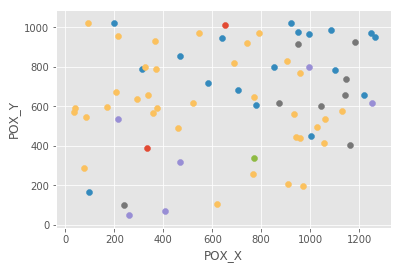

In [695]:
for i in range(len(spec[0])):
    for j in range(len(Density_BY_ABBR_OP)):
        if Density_BY_ABBR_OP.index[j][2] == spec[0][i]:
            if spec[4][i] >= Density_BY_ABBR_OP[j] > spec[3][i]:
                plt.style.use('ggplot')
                
                plt.scatter(df[( df['LOT_ID']==Density.index[j][0]) & (df['DEFECT_CODE_DESC']==Density.index[j][1])].POX_X/1000,
                           df[( df['LOT_ID']==Density.index[j][0]) & (df['DEFECT_CODE_DESC']==Density.index[j][1])].POX_Y/1000)
                plt.xlabel('POX_X')
                plt.ylabel('POX_Y')
                #Eplt.savefig('C:\\Users\\Andyou\\Desktop\\AOI_scatter\\img.png')
                #lt.figure(figsize=(10,10))
                #plt.show()
                              # figure 儲存為二進位檔案
                buffer = BytesIO()
                plt.savefig(buffer)  
                plot_data = buffer.getvalue()

                # 圖片資料轉為 HTML 格式
                imb = base64.b64encode(plot_data)  
                ims = imb.decode()
                imd = "data:image/png;base64,"+ims
                scatter = "<h1>散佈圖"+"_"+Density_BY_ABBR_OP.index[j][2]+"</h1>" + """<img src="%s """ % imd  
                
                    #39 測試用
                request_data1 = {
                    'strMailCode': 'sDM8fpGZVQ8=', #MailCode
                    'strRecipients':'andyou@auo.com', #收件人
                    'strCopyRecipients':'andyou@auo.com', #副本
                    'strSubject':'AOI異常通知', #標題
                    'strBody':'<b><font color="#E00000">'+Density_BY_ABBR_OP.index[j][0]+' </font></b>'+'slot '+'<b><font color="#E00000">'+str(b)+'</font></b>'+
                    ' suffered '+'<b><font color="#E00000">'+Density_BY_ABBR_OP.index[j][2]+'</font></b>'+' issue.'+'<br>'+'<br>'+ 
                    """<table border="1">
                         <tr>
                         <td>要求確認機台狀況(mail)</td>
                         <td><b><font color="#ff8000">%s</font></b></td>
                         </tr>
                         <tr>
                         <td>單批異常立刻停機(mail+hold)</td>
                         <td><b><font color="#ff0000">%s</font></b></td>
                         </tr>
                         <tr>
                         <td>Defect Qty</td>
                         <td>%s</td>
                         </tr>
                         <tr>
                         <td>Sheet Qty</td>
                         <td>%s</td>
                         </tr>
                          <tr>
                         <td>Density</td>
                         <td><b>%s</b></td>
                         </tr>
                        </table>""" % (str(spec[3][i]),str(spec[4][i]),str(DEFECT_COUNT['DEFECT_COUNT'][Density_BY_ABBR_OP.index[j][0]][Density_BY_ABBR_OP.index[j][2]]),str(LOT_COUNT['LOT_COUNT'][Density_BY_ABBR_OP.index[j][0]]),str(Density_BY_ABBR_OP[j]))+
                    str(df2)+'<a href="http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1907/31/KO-32B/JQ99H75T00/JQ99H75T00-01/0753/RVEXTRA_HEAD2_50X0010.JPG"><img src="http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1907/31/KO-32B/JQ99H75T00/JQ99H75T00-01/0753/RVEXTRA_HEAD2_50X0010.JPG" /></a>'+
                    scatter,  #字串，可帶入html body
                    'strFileBase64String':'img.png:'+str(encoded_string) #夾檔案 需先將圖片轉base64， 格式要為: 'XXX.png' +   ':' + encoded_string
                    }

response1 = client.service.ManualSend_39(**request_data1)
response1
 


                

In [37]:
df2 = df.drop(labels=["OPER_ID","EQP_ID","UNIT_ID","LOGOFF_TIME","POX_X","POX_Y"],axis="columns")
df2 = df2[0:5]

df2 = df2.to_html()
print(df2)
import base64
with open("C:\\Users\\Andyou\\Desktop\\AOI_scatter\\img.png", "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())
    encoded_string = encoded_string.decode('utf-8')  #去掉 b'XXXX' 
    #39 測試用
request_data1 = {
    'strMailCode': 'sDM8fpGZVQ8=', #MailCode
    'strRecipients':'andyou@auo.com; HsinhungSung@auo.com', #收件人
    'strCopyRecipients':'andyou@auo.com', #副本
    'strSubject':'AOI異常通知(TEST)', #標題
    'strBody':'<font color="#E00000">我是深紅色的文字</font><br>'+str(df2)+'<a href="http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1907/31/KO-32B/JQ99H75T00/JQ99H75T00-01/0753/RVEXTRA_HEAD2_50X0010.JPG"><img src="http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1907/31/KO-32B/JQ99H75T00/JQ99H75T00-01/0753/RVEXTRA_HEAD2_50X0010.JPG" /></a>'+
    '<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtAAAALQCAYAAAC5V0ecAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMS4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvNQv5yAAAIABJREFUeJzt3X2MnXWd9/HPMGOL06HtPFBIC0YqkBUo8lDSLi604riwILkJKllBYmVvaxmhKSjykF2yi8Gt65Y2lWJLJEWBuGuUdldYNWlqyyrWnT5uKS6oVMWt2IeZ0g4V2s6c+w90bliKyw975nQ6r1dCwrnmzMzv+ubK9J1rfnNOXaVSqQQAAHhDjqj1AgAAYDAR0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUKCh1gsYSrZs2VLrJRx22trasn379lov47BjrtVhrgefmVaHuVbHYJrr2LFja72EQ5o70AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABRoqPUCBtI999yTtWvXZtSoUZkzZ06SpKenJ3Pnzs22bdty9NFH54YbbkhTU1MqlUoWL16cdevWZfjw4eno6Mj48eOTJCtWrMjDDz+cJLn88sszderUWp0SAAADbEjdgZ46dWpuu+22Vx1bunRpJkyYkPnz52fChAlZunRpkmTdunV57rnnMn/+/EyfPj1f/vKXk7wc3N/4xjfyuc99Lp/73OfyjW98Iz09PQN+LgAA1MaQCuhTTjklTU1NrzrW2dmZKVOmJEmmTJmSzs7OJMnq1atz/vnnp66uLieffHJeeOGFdHd3Z/369Tn99NPT1NSUpqamnH766Vm/fv2AnwsAALUxpAL6QJ5//vk0NzcnSZqbm7Nr164kSVdXV9ra2vqf19ramq6urnR1daW1tbX/eEtLS7q6ugZ20QAA1MyQ2gNdolKpvOZYXV3dAZ/7eseXLVuWZcuWJUlmz579qiDn4GhoaDDXKjDX6jDXg89Mq8Ncq8NcDx9DPqBHjRqV7u7uNDc3p7u7OyNHjkzy8h3n7du39z9vx44daW5uTktLS5588sn+411dXTnllFMO+LXb29vT3t7e//iVX4+Do62tzVyrwFyrw1wPPjOtDnOtjsE017Fjx9Z6CYe0Ib+FY+LEiVm5cmWSZOXKlTnnnHP6jz/22GOpVCp5+umn09jYmObm5pxxxhnZsGFDenp60tPTkw0bNuSMM86o5SkAADCAhtQd6Hnz5uXJJ5/M7t27M2PGjFxxxRW57LLLMnfu3CxfvjxtbW258cYbkyRnnnlm1q5dm5kzZ2bYsGHp6OhIkjQ1NeUDH/hAbr311iTJBz/4wdf8YSIAAIevusqBNvtSFVu2bKn1Eg47g+nXYYOJuVaHuR58Zlod5lodg2mutnD8YUN+CwcAAJQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUKCh1gs4VDzyyCNZvnx56urqcvzxx6ejoyM7d+7MvHnz0tPTkxNOOCHXX399Ghoasm/fvtx999155plnctRRR2XWrFkZM2ZMrU8BAIAB4A50kq6urnz729/O7NmzM2fOnPT19eXxxx/Pgw8+mEsuuSTz58/PiBEjsnz58iTJ8uXLM2LEiHzxi1/MJZdckoceeqjGZwAAwEAR0L/T19eXvXv3pre3N3v37s3o0aOzadOmTJ48OUkyderUdHZ2JklWr16dqVOnJkkmT56cJ554IpVKpVZLBwBgANnCkaSlpSWXXnpprr322gwbNizvete7Mn78+DQ2Nqa+vr7/OV1dXUlevmPd2tqaJKmvr09jY2N2796dkSNH1uwcAAAYGAI6SU9PTzo7O7NgwYI0Njbmrrvuyvr161/3+Qe621xXV/eaY8uWLcuyZcuSJLNnz05bW9vBWzRJkoaGBnOtAnOtDnM9+My0Osy1Osz18CGgk2zcuDFjxozpv4M8adKkPPXUU9mzZ096e3tTX1+frq6utLS0JElaW1uzY8eOtLa2pre3N3v27ElTU9Nrvm57e3va29v7H2/fvn1gTmgIaWtrM9cqMNfqMNeDz0yrw1yrYzDNdezYsbVewiHNHui8fEH/5Cc/yUsvvZRKpZKNGzfmuOOOy6mnnppVq1YlSVasWJGJEycmSc4+++ysWLEiSbJq1aqceuqpB7wDDQDA4ccd6CQnnXRSJk+enJtvvjn19fV5+9vfnvb29px11lmZN29e/umf/iknnHBCLrjggiTJBRdckLvvvjvXX399mpqaMmvWrBqfAQAAA6Wu4uUjBsyWLVtqvYTDzmD6ddhgYq7VYa4Hn5lWh7lWx2Caqy0cf5gtHAAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUKCh1gs4VLzwwgtZuHBhnn322dTV1eXaa6/N2LFjM3fu3Gzbti1HH310brjhhjQ1NaVSqWTx4sVZt25dhg8fno6OjowfP77WpwAAwABwB/p3Fi9enDPOOCPz5s3LF77whYwbNy5Lly7NhAkTMn/+/EyYMCFLly5Nkqxbty7PPfdc5s+fn+nTp+fLX/5yjVcPAMBAEdBJ9uzZkx//+Me54IILkiQNDQ0ZMWJEOjs7M2XKlCTJlClT0tnZmSRZvXp1zj///NTV1eXkk0/OCy+8kO7u7pqtHwCAgWMLR5KtW7dm5MiRueeee/KLX/wi48ePz7Rp0/L888+nubk5SdLc3Jxdu3YlSbq6utLW1tb/+a2trenq6up/LgAAhy8BnaS3tzebN2/ONddck5NOOimLFy/u365xIJVK5TXH6urqXnNs2bJlWbZsWZJk9uzZr4puDo6GhgZzrQJzrQ5zPfjMtDrMtTrM9fAhoPPyHeTW1tacdNJJSZLJkydn6dKlGTVqVLq7u9Pc3Jzu7u6MHDmy//nbt2/v//wdO3Yc8O5ze3t72tvb+x+/8nM4ONra2sy1Csy1Osz14DPT6jDX6hhMcx07dmytl3BIswc6yejRo9Pa2potW7YkSTZu3JjjjjsuEydOzMqVK5MkK1euzDnnnJMkmThxYh577LFUKpU8/fTTaWxstH0DAGCIcAf6d6655prMnz8/+/fvz5gxY9LR0ZFKpZK5c+dm+fLlaWtry4033pgkOfPMM7N27drMnDkzw4YNS0dHR41XDwDAQKmrHGhDL1Xx+zvcHDyD6ddhg4m5Voe5HnxmWh3mWh2Daa62cPxhtnAAAEABAQ0AAAUENAAAFBDQAABQYFAF9O23355f//rXtV4GAABD2KAK6AkTJuS2227Lv/7rvx7w3QABAKDaBlVAf+hDH8pnP/vZrF69Orfddlt++ctfpq+v71X/AQBANQ26N1I57rjjcscdd+Qf//Efc9NNN73m4//8z/9cg1UBADBUDLqA3rVrV+67775s3rw5N998c44//vhaLwkAgCFkUAX0Y489lq985St597vfnTlz5uTII4+s9ZIAABhiBlVAf/Ob38ynP/3pvPOd76z1UgAAGKIG1R8RfuELX3jD8fypT32qyqsBAGAoGlQBPWzYsDf83G3btlVxJQAADFWDKqBL1NXV1XoJAAAchg7bgAYAgGoQ0AAAUOCwDWhv9Q0AQDUMqoD+396qe9euXf3/P3369GovBwCAIWhQBfStt96an//85wf82IoVK3LjjTf2P/6zP/uzAVoVAABDyaB6I5Xzzz8/f/u3f5uLLrooH/zgB9PQ0JCtW7fm3nvvzbZt214V0AAAUA2DKqAvueSSTJw4Mffee29uuummTJo0Kd/97nfT3t6ez3zmM0WvEw0AAG/GoNrCkSTHHHNMPvrRj2bXrl1ZsmRJpkyZkquuuko8AwAwIAZVQPf29ubrX/96br/99lx66aX5u7/7u2zcuDF33HFHtm7dWuvlAQAwBAyqgP7MZz6TTZs25XOf+1wuu+yy/Mmf/Ek+//nP5+STT87NN9+cb33rW7VeIgAAh7lBtQf6fe97Xy688MJXvU13Q0ND/vIv/zKTJ0/OokWLcumll9ZwhQAAHO4GVUBfdNFFr/uxt7/97bnzzjsHcDUAAAxFgyqgk2TPnj155JFHsnHjxuzatSsjR47MhAkTcvHFF6epqanWywMA4DA3qAK6q6srf/M3f5MjjzwykyZNSnNzc7q7u/OjH/0oK1euzGc/+9m0tLTUepkAABzGBlVAP/TQQznttNMyY8aMV+2D/tCHPpQvfelLefDBBzNz5swarhAAgMPdoHoVjvXr1+fKK698VTwnSV1dXa688sps2LChRisDAGCoGFQBvXfv3jQ2Nh7wY42Njdm3b98ArwgAgKFmUAX08ccfn//4j/844Mc6Ozszbty4AV4RAABDzaDaA/2BD3wg8+fPT1dXVyZPntz/R4Q//OEP8/DDD+e6666r9RIBADjMDaqAPvvss3PttdfmgQceyIMPPth/vLW1NdOnT8/EiRNruDoAAIaCQRXQL730Up555pkcf/zxOfHEE/MXf/EXGTlyZMaOHVvrpQEAMEQMqj3Q9913X9asWZPjjjsuv/rVr/L444+LZwAABtSgCuj169fnr//6r/ORj3wkt956a9asWVPrJQEAMMQMqoB+6aWX0tzcnCRpa2vLnj17arwiAACGmkG1B7q3tzdPPPFE/+O+vr5XPU6S0047baCXBQDAEDKoAnrUqFH50pe+1P+4qanpVY/r6upy991312JpAAAMEYMqoBcsWFDrJQAAMMQNqj3QAABQawIaAAAKCGgAACggoAEAoICABgCAAgIaAAAKCGgAACggoAEAoICABgCAAgIaAAAKCGgAACggoAEAoICABgCAAgIaAAAKCGgAACggoAEAoICABgCAAgIaAAAKCGgAACggoAEAoICABgCAAgIaAAAKCGgAACggoAEAoICABgCAAgIaAAAKCGgAACggoAEAoICABgCAAgIaAAAKCGgAACggoAEAoICABgCAAgIaAAAKCGgAACggoAEAoICABgCAAgIaAAAKCGgAACggoAEAoICABgCAAgIaAAAKCGgAACggoAEAoICABgCAAgIaAAAKCGgAACggoAEAoICABgCAAg21XsChpK+vL7fccktaWlpyyy23ZOvWrZk3b156enpywgkn5Prrr09DQ0P27duXu+++O88880yOOuqozJo1K2PGjKn18gEAGADuQL/Cv/3bv2XcuHH9jx988MFccsklmT9/fkaMGJHly5cnSZYvX54RI0bki1/8Yi655JI89NBDtVoyAAADTED/zo4dO7J27dq8973vTZJUKpVs2rQpkydPTpJMnTo1nZ2dSZLVq1dn6tSpSZLJkyfniSeeSKVSqcm6AQAYWAL6d+6///585CMfSV1dXZJk9+7daWxsTH19fZKkpaUlXV1dSZKurq60trYmSerr69PY2Jjdu3fXZuEAAAwoe6CTrFmzJqNGjcr48eOzadOm//X5B7rb/PvwfqVly5Zl2bJlSZLZs2enra3tj18sr9LQ0GCuVWCu1WGuB5+ZVoe5Voe5Hj4EdJKnnnoqq1evzrp167J379789re/zf333589e/akt7c39fX16erqSktLS5KktbU1O3bsSGtra3p7e7Nnz540NTW95uu2t7envb29//H27dsH7JyGira2NnOtAnOtDnM9+My0Osy1OgbTXMeOHVvrJRzSbOFIcuWVV2bhwoVZsGBBZs2aldNOOy0zZ87MqaeemlWrViVJVqxYkYkTJyZJzj777KxYsSJJsmrVqpx66qkHvAMNAMDhR0D/AVdddVUeeeSRXH/99enp6ckFF1yQJLngggvS09OT66+/Po888kiuuuqqGq8UAICBUlfx8hEDZsuWLbVewmFnMP06bDAx1+ow14PPTKvDXKtjMM3VFo4/zB1oAAAoIKABAKCAgAYAgAICGgAACghoAAAoIKABAKCAgAYAgAICGgAACghoAAAoIKABAKCAgAYAgAICGgAACghoAAAoIKABAKCAgAYAgAICGgAACghoAAAoIKABAKCAgAYAgAICGgAACghoAAAoIKABAKBAQ60XAAB9255L/uWhVHZ2pW50S/J/rsoRRx9b62UBHJCABqCm+rY9l8rc25NtzyVJKknyzFPpu+EOEQ0ckmzhAKC2/uWh/nju97s70gCHIgENQE1VdnYVHQeoNQENQE3VjW4pOg5QawIagNr6P1cl/3Ov89HHvnwc4BDkjwgBqKkjjj42fTfc4VU4gEFDQANQc0ccfWzyfz9V62UAvCG2cAAAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFCgodYLOBRs3749CxYsyM6dO1NXV5f29vZcfPHF6enpydy5c7Nt27YcffTRueGGG9LU1JRKpZLFixdn3bp1GT58eDo6OjJ+/PhanwYAAAPAHegk9fX1ufrqqzN37tzceeed+e53v5tf/epXWbp0aSZMmJD58+dnwoQJWbp0aZJk3bp1ee655zJ//vxMnz49X/7yl2t8BgAADBQBnaS5ubn/DvJb3/rWjBs3Ll1dXens7MyUKVOSJFOmTElnZ2eSZPXq1Tn//PNTV1eXk08+OS+88EK6u7trtn4AAAaOgP4ftm7dms2bN+fEE0/M888/n+bm5iQvR/auXbuSJF1dXWlra+v/nNbW1nR1ddVkvQAADCx7oF/hxRdfzJw5czJt2rQ0Nja+7vMqlcprjtXV1b3m2LJly7Js2bIkyezZs18V3RwcDQ0N5loF5lod5nrwmWl1mGt1mOvhQ0D/zv79+zNnzpycd955mTRpUpJk1KhR6e7uTnNzc7q7uzNy5MgkL99x3r59e//n7tixo/9O9Su1t7envb29//ErP4eDo62tzVyrwFyrw1wPPjOtDnOtjsE017Fjx9Z6CYc0Wzjy8h3lhQsXZty4cXn/+9/ff3zixIlZuXJlkmTlypU555xz+o8/9thjqVQqefrpp9PY2HjAgAYA4PDjDnSSp556Ko899lje9ra35aabbkqSfPjDH85ll12WuXPnZvny5Wlra8uNN96YJDnzzDOzdu3azJw5M8OGDUtHR0ctlw8AwACqqxxoQy9VsWXLllov4bAzmH4dNpiYa3WY68FnptVhrtUxmOZqC8cfZgsHAAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFBAQAMAQAEBDQAABQQ0AAAUENAAAFCgodYLGKzWr1+fxYsXp6+vL+9973tz2WWX1XpJAAAMAHeg34S+vr7cd999ue222zJ37tz84Ac/yK9+9ataLwsAgAEgoN+En/70pzn22GNzzDHHpKGhIeeee246OztrvSwAAAaAgH4Turq60tra2v+4tbU1XV1dNVwRAAADxR7oN6FSqbzmWF1d3WuOLVu2LMuWLUuSzJ49O2PHjq362oYic60Oc60Ocz34zLQ6zLU6zPXw4A70m9Da2podO3b0P96xY0eam5tf87z29vbMnj07s2fPzi233DKQSxwyzLU6zLU6zPXgM9PqMNfqMNfDh4B+E97xjnfk17/+dbZu3Zr9+/fn8ccfz8SJE2u9LAAABoAtHG9CfX19rrnmmtx5553p6+vLe97znhx//PG1XhYAAANAQL9JZ511Vs4666w3/Pz29vYqrmboMtfqMNfqMNeDz0yrw1yrw1wPH3WVA/1FHAAAcED2QAMAQAFbOAaAt/1+c7Zv354FCxZk586dqaurS3t7ey6++OL09PRk7ty52bZtW44++ujccMMNaWpqSqVSyeLFi7Nu3boMHz48HR0dGT9+fK1P45DV19eXW265JS0tLbnllluydevWzJs3Lz09PTnhhBNy/fXXp6GhIfv27cvdd9+dZ555JkcddVRmzZqVMWPG1Hr5h6QXXnghCxcuzLPPPpu6urpce+21GTt2rOv1j/TII49k+fLlqaury/HHH5+Ojo7s3LnT9Vronnvuydq1azNq1KjMmTMnSd7Uz9MVK1bk4YcfTpJcfvnlmTp1aq1O6ZBwoLk+8MADWbNmTRoaGnLMMceko6MjI0aMSJIsWbIky5cvzxFHHJGPfexjOeOMM5JohUGnQlX19vZWrrvuuspzzz1X2bdvX+XTn/505dlnn631sgaFrq6uys9+9rNKpVKp7NmzpzJz5szKs88+W3nggQcqS5YsqVQqlcqSJUsqDzzwQKVSqVTWrFlTufPOOyt9fX2Vp556qnLrrbeMUHrwAAAK90lEQVTWbO2Dwbe+9a3KvHnzKn//939fqVQqlTlz5lS+//3vVyqVSmXRokWV7373u5VKpVL5zne+U1m0aFGlUqlUvv/971fuuuuu2ix4EPjiF79YWbZsWaVSqVT27dtX6enpcb3+kXbs2FHp6OiovPTSS5VK5eXr9Hvf+57r9U3YtGlT5Wc/+1nlxhtv7D9Wen3u3r278slPfrKye/fuV/3/UHagua5fv76yf//+SqXy8ox/P9dnn3228ulPf7qyd+/eym9+85vKddddV+nt7dUKg5AtHFXmbb/fvObm5v47Hm9961szbty4dHV1pbOzM1OmTEmSTJkypX+eq1evzvnnn5+6urqcfPLJeeGFF9Ld3V2z9R/KduzYkbVr1+a9731vkpffHGjTpk2ZPHlykmTq1Kmvmuvv7zBNnjw5TzzxxAHfTGio27NnT3784x/nggsuSJI0NDRkxIgRrteDoK+vL3v37k1vb2/27t2b0aNHu17fhFNOOSVNTU2vOlZ6fa5fvz6nn356mpqa0tTUlNNPPz3r168f8HM5lBxoru9617tSX1+fJDn55JP73624s7Mz5557bt7ylrdkzJgxOfbYY/PTn/5UKwxCtnBU2YHe9vsnP/lJDVc0OG3dujWbN2/OiSeemOeff77/jWuam5uza9euJC/Puq2trf9zfv8W6wd6k5uh7v77789HPvKR/Pa3v02S7N69O42Njf0/8FtaWvp/4L/yGq6vr09jY2N2796dkSNH1mbxh6itW7dm5MiRueeee/KLX/wi48ePz7Rp01yvf6SWlpZceumlufbaazNs2LC8613vyvjx412vB0np9fk//0175ew5sOXLl+fcc89N8vJcTzrppP6PvXJ+WmFwcQe6yg505+NAb/vN63vxxRczZ86cTJs2LY2Nja/7PLN+Y9asWZNRo0a94f225vrG9Pb2ZvPmzfnzP//z/MM//EOGDx+epUuXvu7zzfWN6enpSWdnZxYsWJBFixblxRdf/IN3PM314CiZo/m+vocffjj19fU577zzkhx4rq933FwPbe5AV9kbfdtvDmz//v2ZM2dOzjvvvEyaNClJMmrUqHR3d6e5uTnd3d39d5ZaW1uzffv2/s816wN76qmnsnr16qxbty579+7Nb3/729x///3Zs2dPent7U19fn66urrS0tCT5/9dwa2trent7s2fPntf8upKX59Ta2tp/d2ny5MlZunSp6/WPtHHjxowZM6Z/bpMmTcpTTz3lej1ISq/PlpaWPPnkk/3Hu7q6csoppwz4ugeDFStWZM2aNbn99tv7Y/h/NsErr12tMLi4A11l3vb7zatUKlm4cGHGjRuX97///f3HJ06cmJUrVyZJVq5cmXPOOaf/+GOPPZZKpZKnn346jY2NfgAdwJVXXpmFCxdmwYIFmTVrVk477bTMnDkzp556alatWpXk5R/8v79Ozz777KxYsSJJsmrVqpx66qnujBzA6NGj09rami1btiR5OfyOO+441+sfqa2tLT/5yU/y0ksvpVKp9M/V9XpwlF6fZ5xxRjZs2JCenp709PRkw4YN/a8iwf+3fv36/Mu//EtuvvnmDB8+vP/4xIkT8/jjj2ffvn3ZunVrfv3rX+fEE0/UCoOQN1IZAGvXrs1XvvKV/rf9vvzyy2u9pEHhv/7rv3L77bfnbW97W/8/gB/+8Idz0kknZe7cudm+fXva2tpy44039r/s0n333ZcNGzZk2LBh6ejoyDve8Y4an8WhbdOmTfnWt76VW265Jb/5zW9e87Jgb3nLW7J3797cfffd2bx5c5qamjJr1qwcc8wxtV76IennP/95Fi5cmP3792fMmDHp6OhIpVJxvf6Rvv71r+fxxx9PfX193v72t2fGjBnp6upyvRaaN29ennzyyezevTujRo3KFVdckXPOOaf4+ly+fHmWLFmS5OWXsXvPe95Ty9OquQPNdcmSJdm/f3//bz9OOumkTJ8+PcnL2zq+973v5Ygjjsi0adNy5plnJtEKg42ABgCAArZwAABAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AA18MlPfjJXXXVVrr766nz84x/PPffckxdffDFJsmbNmtx66625+uqrc80112T+/Pmvepvfb3/72/nUpz6V/fv39x979NFH85nPfCa9vb2v+z03b96cj370o3nuuef6jz3zzDOZNm1atm7dWoWzBDg8CWiAGrn55pvzwAMP5POf/3x+9rOf5Zvf/GZWrVqV+fPn5+KLL859992Xu+66Kw0NDbn99tvT09OTJLnwwgvT2NiYhx9+OEnym9/8Jl//+tczY8aM1NfXv+73O+GEE3LhhRdm0aJFqVQq2b9/f770pS/liiuuyJgxYwbknAEOBwIaoMZaWlpyxhln5Je//GW++tWv5vLLL895552XYcOGZfTo0ZkxY0aOPPLIPProo0mSI444Itdee20effTR/OIXv8iiRYty4YUXZvz48f/r9/rQhz6U7u7uLFu2LEuWLMmRRx6Ziy66qNqnCHBYEdAANbZ9+/asW7cuw4cPz/bt2/Onf/qnr/r4EUcckUmTJuU///M/+4+NHTs2l112We64447s2LEjH/zgB9/Q93rLW96SGTNm5KGHHsojjzySGTNm5Igj/FMAUKKh1gsAGKq+8IUvpL6+Po2NjTnrrLPy7ne/O6tWrcro0aNf89zRo0dn9+7drzr2zne+M1/72tfS3t6eYcOGveHv+7a3vS319fUZO3Zsxo0b90efB8BQI6ABauSmm27K6aef3v/4v//7v5MkO3fufM2e5J07d+aoo47qf7x///7ce++9ueiii/Kd73wnF1xwQY455pg39H2/+tWv5p3vfGeeeeaZ/OAHP8i73/3ug3A2AEOH39sBHCLGjh2b1tbW/PCHP3zV8b6+vvzoRz/KhAkT+o994xvfyKhRo/Kxj30s73vf+3Lvvfe+oe+xcePGdHZ2Zvr06fn4xz+e+++/v/+PEwF4YwQ0wCGirq4uV199dR5++OF8//vfz969e7Nz584sXLgwe/bsySWXXJIk+fnPf55vf/vb+cQnPpG6urpcccUV2bZtW773ve/9wa//4osvZtGiRZk2bVpGjhyZM888MxMmTMj9998/AGcHcPgQ0ACHkHPPPTfXXXddHn300fzVX/1Vbrjhhuzduzef/exnc9RRR6Wvry8LFy7M5ZdfnmOPPTZJMmzYsHziE5/Igw8+mJ07d77u1/7a176WcePG5bzzzus/Nm3atKxfvz4bNmyo+rkBHC7qKpVKpdaLAACAwcIdaAAAKOBVOAAOI//+7/9+wD8oPProo3PXXXfVYEUAhx9bOAAAoIAtHAAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAAQENAAAFBDQAABQQ0AAAUEBAAwBAgf8H+Aqwx5MIqp4AAAAASUVORK5CYII=', 
    #字串，可帶入html body
    'strFileBase64String':'img.png:'+str(encoded_string) #夾檔案 需先將圖片轉base64， 格式要為: 'XXX.png' +   ':' + encoded_string
    }
response1 = client.service.ManualSend_39(**request_data1)
response1


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>LOT_ID</th>
      <th>ABBR_NO</th>
      <th>DEFECT_CODE_DESC</th>
      <th>OP_ID</th>
      <th>SHEET_ID</th>
      <th>DEFECT_COUNT</th>
      <th>KO_ID</th>
      <th>IMG_FILE_PATH</th>
      <th>TEST_TIME</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>JQ99H93260</td>
      <td>JQ</td>
      <td>I-Defect</td>
      <td>0040</td>
      <td>JQ99H93260-01</td>
      <td>1</td>
      <td>KO-12B</td>
      <td>&lt;a href="http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1909/11/KO-12B/JQ99H93260/JQ99H93260-01/0600/NGID012500102.JPG" &gt;&lt;img width="200" height="200" src="http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1909/11/KO-12B/JQ99H93260/JQ99H93260-01/0600/NGID012500102.JPG" /&gt;&lt;/a&gt;</td>
      <td>2019/09/11 06:00:42</td>
    </tr>
    <tr>
      <th>1</th>
      <td>JQ99H93260</td>
      <td>JQ</td>
      <td>I-Defect</td>
      <td>0040</td>
      <td>JQ9

True

In [896]:
# 引入 requests 模組
import requests

# 使用 GET 方式下載普通網頁
r = requests.get('http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1907/31/KO-32B/JQ99H75T00/JQ99H75T00-01/0753/RVEXTRA_HEAD2_50X0010.JPG')
r = r.content
r

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc0\x00\x11\x08\x04\x0b\x05d\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7

In [1]:
import os

# 找出檔案位置
import os
file_path = os.getcwd()

# 找到 python 執行檔位置
import sys
python_path = (sys.executable)


print('程式或指令碼:', python_path)
print('新增引數:', os.path.join(file_path, 'AOI檢出異常通知.py'))
print('開始位置:', file_path)

程式或指令碼: C:\Anaconda3\python.exe
新增引數: C:\Users\Andyou\Desktop\python專案\AOI檢出異常通知.py
開始位置: C:\Users\Andyou\Desktop\python專案


In [87]:
import time
conn = cx_Oracle.connect("l5dtbl_query", "l5dtbl$query", "10.1.100.152:1522/L5DH")

cur = conn.cursor() # 獲取操作遊標，也就是開始操作
cur.arraysize = 5000
# execute a query returning the results to the cursor
print("Starting cursor at", time.ctime())

#查詢資料庫
sql ="select O.abbr_no,O.lot_id, O.sheet_id, O.defect_code_desc, O.op_id,O.ko_id,O.pox_x, O.pox_y, O.img_file_path, E.OPER_ID,E.EQP_ID,E.UNIT_ID,E.LOGOFF_TIME,O.TEST_TIME\
 from\
	(select to_char(test_time,'yyyy/mm/dd hh24:mi:ss') test_time,tft_lot_id lot_id, tft_sheet_id sheet_id,defect_code_desc, substr(op_id,1,4) op_id, eqp_id ko_id,\
	substr(abbr_no,1,2) abbr_no, pox_x, pox_y, img_file_path\
		from aryods.h_dax_aoidefect_ods \
		where defect_code_desc not in 'null' ) O\
 join \
 (\
	SELECT*FROM \
       		 (SELECT B.LOT_ID,B.SHEET_ID_CHIP_ID SHEET_ID,SUBSTR(B.OP_ID,1,4) OPER_ID,B.EQP_ID,A.UNIT_ID,\
               	 to_char(B.LOGOFF_TIME,'YYYY/MM/DD HH24:MI:SS') AS LOGOFF_TIME,\
               	 RANK() OVER (PARTITION BY B.SHEET_ID_CHIP_ID,B.OP_ID ORDER BY B.LOGOFF_TIME DESC) RANK \
                   	 FROM ARYODS.H_SHEET_OPER_ODS B Left Outer Join ARYODS.H_DAX_EQPUNIT_ODS A ON  \
                        B.SHEET_ID_CHIP_ID=A.SHEET_ID \
                        AND B.EQP_ID=A.EQP_ID \
                        AND SUBSTR(B.OP_ID,1,4)=SUBSTR(A.OP_ID,1,4) \
                        AND to_char(B.LOGOFF_TIME,'yyyy/mm/dd hh24:mi:ss')<=to_char(A.PROCESS_TIME,'yyyy/mm/dd hh24:mi:ss')  \
               ) C WHERE RANK=1 \
 ) E\
 on O.sheet_id = E.SHEET_ID\
 and O.lot_id = E.lot_id\
 and O.test_time > E.LOGOFF_TIME\
 where to_date(TEST_TIME,'yyyy/mm/dd hh24:mi:ss') > sysdate-0.25\
                   " 
cur.execute(sql) # 執行查詢語句 抓六個小時資料更新
print("Finished cursor at", time.ctime())

# raw data
rows = cur.fetchmany(cur.arraysize) # 獲取查詢結果
col_result = cur.description #獲取查詢結果的欄位描述
columns = []
for i in range(len(col_result)):
    columns.append(col_result[i][0])  # 獲取欄位名，以列表形式儲存
df = pd.DataFrame(rows,columns=columns)   #轉dataframe格式
df.head()

Starting cursor at Tue Sep 17 15:23:41 2019
Finished cursor at Tue Sep 17 15:50:34 2019


,ABBR_NO,LOT_ID,SHEET_ID,DEFECT_CODE_DESC,OP_ID,KO_ID,POX_X,POX_Y,IMG_FILE_PATH,OPER_ID,EQP_ID,UNIT_ID,LOGOFF_TIME,TEST_TIME
0,JQ,JQ99H8B540,JQ99H8B540-01,I-Others,1140,KO-11B,41857,346389,http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1909/17/KO-11B/JQ99H8B540/JQ99H8B540-01/1150/KO-11B.7400.JQ40.JQ99H8B540.JQ99H8B540-01.44.b.1568692281.jpg,0000,WU-01B,None,2019/08/28 03:56:47,2019/09/17 11:50:45
1,JQ,JQ99H8B540,JQ99H8B540-01,I-Others,1140,KO-11B,158094,338473,http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1909/17/KO-11B/JQ99H8B540/JQ99H8B540-01/1150/KO-11B.7400.JQ40.JQ99H8B540.JQ99H8B540-01.40.b.1568692281.jpg,0000,WU-01B,None,2019/08/28 03:56:47,2019/09/17 11:50:45
2,JQ,JQ99H8B540,JQ99H8B540-01,I-Nothing,1140,KO-11B,34201,340543,http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1909/17/KO-11B/JQ99H8B540/JQ99H8B540-01/1150/KO-11B.7400.JQ40.JQ99H8B540.JQ99H8B540-01.39.b.1568692281.jpg,0000,WU-01B,None,2019/08/28 03:56:47,2019/09/17 11:50:45
3,JQ,JQ99H8B540,JQ99H8B540-01,I-Nothing,1140,KO-11B,29732,331200,http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1909/17/KO-11B/JQ99H8B540/JQ99H8B540-01/1150/KO-11B.7400.JQ40.JQ99H8B540.JQ99H8B540-01.4.b.1568692281.jpg,0000,WU-01B,None,2019/08/28 03:56:47,2019/09/17 11:50:45
4,JQ,JQ99H8B540,JQ99H8B540-01,I-Nothing,1140,KO-11B,1220667,246923,http://hyadiwa1/dms/L5DAIDI/ARYAOI_L5D/1909/17/KO-11B/JQ99H8B540/JQ99H8B540-01/1150/KO-11B.7400.JQ40.JQ99H8B540.JQ99H8B540-01.116.b.1568692281.jpg,0000,WU-01B,None,2019/08/28 03:56:47,2019/09/17 11:50:45


(0, 1100)

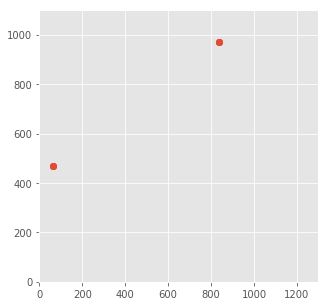

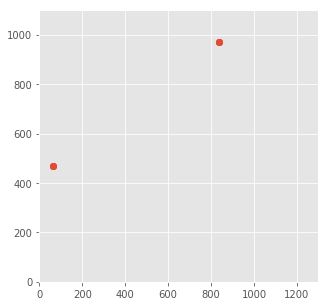

In [39]:
 # 散佈圖
plt.style.use('ggplot')  #使用ggplot美化
plt.figure(figsize=(5,5))
plt.scatter(df[( df['LOT_ID']==Density_BY_ABBR_OP.index[j][0]) & (df['DEFECT_CODE_DESC']==Density_BY_ABBR_OP.index[j][2])].POX_X/1000,
df[( df['LOT_ID']==Density_BY_ABBR_OP.index[j][0]) & (df['DEFECT_CODE_DESC']==Density_BY_ABBR_OP.index[j][2])].POX_Y/1000)
plt.xlim(0, 1300) #固定X axis為1300
plt.ylim(0, 1100) #固定y axis為1100
 # 散佈圖
plt.style.use('ggplot')  #使用ggplot美化
plt.figure(figsize=(5,5))
print(df[( df['LOT_ID']==Density_BY_ABBR_OP.index[j][0]) & (df['DEFECT_CODE_DESC']==Density_BY_ABBR_OP.index[j][2])].groupby(['EQP_ID']))
df[( df['LOT_ID']==Density_BY_ABBR_OP.index[j][0]) & (df['DEFECT_CODE_DESC']==Density_BY_ABBR_OP.index[j][2])].POX_Y/1000
plt.scatter(df[( df['LOT_ID']==Density_BY_ABBR_OP.index[j][0]) & (df['DEFECT_CODE_DESC']==Density_BY_ABBR_OP.index[j][2])].POX_X/1000,
df[( df['LOT_ID']==Density_BY_ABBR_OP.index[j][0]) & (df['DEFECT_CODE_DESC']==Density_BY_ABBR_OP.index[j][2])].POX_Y/1000)
plt.xlim(0, 1300) #固定X axis為1300
plt.ylim(0, 1100) #固定y axis為1100

In [49]:
spec = [['T-M1-Fiber' ,'T-M1-Fiber','T-M1-Fiber','T-M1-Particle','T-M1-Particle',
         'T-M1-Particle','T-M1-Residue','T-Brush defect','T-AS-M2short','T-AS-Particle Small',
         'T-AS-Particle Small','T-AS-Residue','T-AS-Residue','T-AS-Residue','T-AS-Residue',
         'T-AS-SiN Hole','T-M2-Fiber','T-M2-Fiber','T-M2-Fiber','T-M2-Fiber',
         'T-M2-Fiber','T-M2-Fiber','T-M2-Fiber','T-M2-Fiber','T-M2-Fiber',
         'T-M2-Particle','T-M2-Particle','T-M2-Particle','T-M2-Particle','T-M2-Particle',
         'T-M2-Residue','T-ITO1-Hole','T-ITO1-Hole','T-ITO1-Hole','T-ITO1-Hole',
         'T-ITO1-Hole','T-ITO1-Hole','T-ITO1-Hole','T-ITO1-Residue','T-ITO1-Residue',
         'T-PV-Dirt','T-PV-Ring','T-PV-Hole','T-PV-Residue','T-PV-Residue',
         'T-PV-Residue','T-PE-Hole','T-PE-Hole','T-PE-Hole','T-PE-Residue',
         'P-Fiber','P-Fiber','P-M1-Open','P-M1-Residue','P-M1-Residue',
         'P-M1-Short','P-ITO1-Hole','P-ITO1-Hole','P-ITO1-Hole','P-ITO1-Residue',
         'P-ITO1-Residue','E-M1-Al Residue','E-M1-Al Residue','E-M1-Al Residue','E-M1-Al Residue',
         'E-M1-Al Residue','E-M1-Al Residue','E-M1-Al Residue','E-AS-Residue','E-AS-Residue',
         'E-AS-Residue','E-AS-Residue','E-AS-Residue','E-AS-BPADJ','E-TH-No',
         'E-TH-No','E-M2-Residue','E-M2-Residue','E-M2-Residue','E-M2-Residue',
         'E-M2-Residue','E-M2-Short','E-ITO1-Hole','E-ITO1-Hole','E-ITO1-Hole',
         'E-ITO1-Hole','E-ITO1-Residue','E-PV-DP Hole','E-Moly Loss','E-PV-Hole',
         'E-PV-Hole','E-PV-Hole','E-PV-Hole','E-PV-Hole','E-PV-Hole',
         'E-PV-Hole','E-PV-Hole','E-PV-Hole','E-PE-Hole','E-PE-Hole',
         'E-PE-Hole','E-PE-Hole','I-Dust','I-Dust','I-ESD',
         'I-ITO1-Crack','I-AS-Abnormal','I-AS-Discolor','I-M2-Crack','I-M2-Defect',
         'I-MD-Defect','I-Scratch','T-M1-Hillock','T-M1-Mousebite','T-M1-Splash',
         'T-AS-Splash','T-M2-Splash','T-PV-Splash','T-M3-Splash','T-PE-Splash',
         'T-M2-Mousebite','T-M2-Mousebite','T-ITO1-Arcing','T-BP-Arcing','T-PV-Arcing',
         'T-PE-Arcing','P-M2-Defocus','E-AS-Al Ball','E-M2-Dirt','E-M2-Arcing',
         'E-PE-Peeling'
         ]   #defect code (5個一行)
    ,
        ['0100','0105','0025','0100','0105',
         '0205','','','','0205',
         '0690','0205','0699','0690','',
         '','','','','',
         '','','','','',
         '','','','','',
         '','0713','0733','0783','0583',
         '1140','','','0690','',
         '','','','0805','0805',
         '','','','','',
         '0040','0620','','0205','',
         '','','','','0733',
         '','0100','0100','0105','0100',
         '0105','0105','','','',
         '','','','','0380',
         '0690','','','','',
         '','','0583','0783','1140',
         '','','','','0380',
         '0690','0783','0880','0583','0583',
         '1140','2033','','','',
         '','','0220','0713','',
         '','','','','',
         '','','','','',
         '','','','','',
         '','','','','',
         '','','','','',
         ''
        ] # OP_ID (5個一行)
    ,
        [['0000-CLA','0010-SPT'],['0000-CLA','0010-SPT'],['0000-CLA','0010-SPT'],['0010-SPT','0000-CLA'],['0010-SPT','0000-CLA'],
         ['0010-SPT','0000-CLA'],['0010-SPT','0000-CLA'],['0000-CLA','0010-SPT'],'0200-CVD',['0200-CVD','0080-STO'],
         ['0200-CVD','0080-STO'],'0200-CVD','0200-CVD','0200-CVD','0200-CVD',
         '0200-CVD',['0600-SPT','0210-IEX','0670-STO'],['0600-SPT','0210-IEX','0670-STO'],['0600-SPT','0210-IEX','0670-STO'],['0600-SPT','0210-IEX','0670-STO'],
         ['0600-SPT','0210-IEX','0670-STO'],['0600-SPT','0210-IEX','0670-STO'],['0600-SPT','0210-IEX','0670-STO'],['0600-SPT','0210-IEX','0670-STO'],['0600-SPT','0210-IEX','0670-STO'],
         ['0600-SPT','0210-IEX','0670-STO'],['0600-SPT','0210-IEX','0670-STO'],['0600-SPT','0210-IEX','0670-STO'],['0600-SPT','0210-IEX','0670-STO'],['0600-SPT','0250-STO'],
         '0600-SPT',['0710-SPT','0730-IEX'],['0710-SPT','0730-IEX'],['0710-SPT','0730-IEX'],['0710-SPT','0730-IEX'],
         ['0710-SPT','0730-IEX'],['0710-SPT','0730-IEX'],['0710-SPT','0730-IEX'],['0710-SPT','0730-IEX'],['0710-SPT','0730-IEX'],
         ['0800-CVD','0510-CVD'],['0800-CVD','0510-CVD'],['0510-CVD','0800-CVD'],['0800-CVD','0510-CVD','0760-WZO','0697-CLA','0797-CLA','0810-CLA'],['0800-CVD','0510-CVD','0760-WZO','0697-CLA','0797-CLA','0810-CLA'],
         ['0800-CVD','0510-CVD','0760-WZO','0697-CLA','0797-CLA','0810-CLA'],'1000-SPT','1000-SPT','1000-SPT','1000-SPT',
         '0030-IEX','0610-IEX','0030-IEX','0030-IEX','0030-IEX',
         '0030-IEX','0730-IEX','0730-IEX','0730-IEX','0730-IEX',
         '0730-IEX',['0030-IEX','0060-WMO'],['0030-IEX','0060-WMO'],['0030-IEX','0060-WMO'],['0030-IEX','0060-WMO'],
         ['0030-IEX','0060-WMO'],['0030-IEX','0060-WMO'],['0030-IEX','0060-WMO'],['0240-RIE','0210-IEX'],['0240-RIE','0210-IEX'],
         ['0240-RIE','0210-IEX'],['0240-RIE','0210-IEX'],['0240-RIE','0210-IEX'],['0240-RIE','0210-IEX'],['0360-RIE','0320-IEX'],
         ['0360-RIE','0320-IEX'],['0650-RIE','0640-WMO'],['0650-RIE','0640-WMO'],['0650-RIE','0640-WMO'],['0650-RIE','0640-WMO'],
         ['0650-RIE','0640-WMO'],'0650-RIE','0760-WZO','0760-WZO','0760-WZO',
         '0760-WZO','0760-WZO',['0860-RIE','0560-RIE'],['0860-RIE','0560-RIE'],['0360-RIE','0320-IEX'],
         ['0360-RIE','0320-IEX'],['0860-RIE','0820-IEX'],['0860-RIE','0820-IEX'],['0560-RIE','0530-IEX'],['0560-RIE','0530-IEX'],
         ['0560-RIE','0530-IEX'],'0560-RIE',['0860-RIE','0560-RIE','0360-RIE'],'1060-WZO','1060-WZO',
         '1060-WZO','1060-WZO','0210-IEX','0690-ASO',['0200-CVD','0240-RIE','0650-RIE'],
         ['0250-STO','0670-STO'],['0210-IEX','0240-RIE'],['0210-IEX','0240-RIE'],['0600-SPT','0610-IEX','0640-WMO'],'',
         '1130-AT1','','0010-SPT','0010-SPT','0010-SPT',
         '0200-CVD','0600-SPT',['0800-CVD','0510-CVD'],'0410-SPT','1000-SPT',
         ['0600-SPT','0640-WMO'],'0600-SPT','0710-SPT','0510-CVD','0800-CVD',
         '1000-SPT','0610-IEX','0240-RIE',['0650-RIE','0670-STO'],'0650-RIE',
         '1060-WZO'
        ] # OPER_ID (5個一行)
    ,
        ['','','','','',
         '','','','','',
         '','','','','',
         '','PW','LX','LW','JV',
         'JT','JQ','JH','RV','',
         'JV','JT','JQ','JH','',
         '','JY','JY','JY','JY',
         'JY','PR','','','',
         '','','','PR','',
         '','LX','JR','','',
         '','','','','',
         '','JY','JT','','',
         '','','PR','PR','YC',
         'YC','','','JV','JT',
         'JQ','JH','','','',
         '','HH','YQ','LU','YC',
         '','','JY','JY','JY',
         '','','','','',
         '','','','','PW',
         'PW','CK','','JR','LX',
         'LW','','','JY','',
         '','','','','',
         '','','','','',
         '','','','','',
         'JV','','','','',
         '','','','','',
         ''
        ] #ABBR_NO (5個一行)
    ,
        [4,4,4,0.6,0.6,
         0.6,0.5,0.8,1,999,
         7,3,1.5,1.5,1.5,
         999,5,999,999,5,
         5,5,5,5,4,
         0.8,0.8,0.8,0.8,0.6,
         0.8,15,15,15,1,
         1,1.5,20,999,999,
         0.3,5,0.8,5,3,
         2,999,999,15,3,
         20,20,999,999,999,
         0.5,0.6,0.6,5,999,
         999,20,10,10,999,
         999,5,20,2.5,2.5,
         2.5,2.5,2.5,0.8,1,
         1,999,4,1,5,
         2,999,0.5,2,0.5,
         1,999,1,2,0.2,
         0.2,999,999,999,3,
         3,999,999,3,3,
         3,1,15,60,999,
         0.5,0.4,0.15,10,10,
         999,1,999,999,999,
         999,999,999,999,999,
         999,999,999,999,999,
         999,999,999,999,999,
         999
        ] #mail (5個一行)
    ,
        [5,5,5,1,1,
         1,0.6,1,1,15,
         15,4,2,2,2,
         0.5,7,5,5,7,
         7,7,7,7,5,
         1,1,1,1,1,
         1,20,20,20,2,
         2,2,999,0.5,3,
         999,999,1.2,6,4,
         3,150,150,20,5,
         999,999,1,2,1,
         1,1,1,10,4,
         0.4,30,999,999,
         1,1,10,30,3,
         3,3,3,3,1,2,
         2,2,5,2.5,10,
         3,0.8,1,3,1,
         5,1,2,999,0.4,
         0.4,0.6,0.6,0.6,5,
         5,5,0.4,5,5,
         5,3,999,999,0,
         999,0.5,0.25,999,999,
         0,999,3,0,0,
         0,0,0,0,0,
         10,0,0,0,0,
         0,0,0,0,0,
         0
        ] #mail+hold (5個一行)
    ,
        [['0000-CLA','0010-SPT'],['0000-CLA','0010-SPT'],['0000-CLA','0010-SPT'],'0010-SPT','0010-SPT',
         '0010-SPT','0010-SPT','0000-CLA','0200-CVD','0200-CVD',
         '0200-CVD','0200-CVD','0200-CVD','0200-CVD','0200-CVD',
         '0200-CVD','0600-SPT','0600-SPT','0600-SPT','0600-SPT',
         '0600-SPT','0600-SPT','0600-SPT','0600-SPT','0600-SPT',
         '0600-SPT','0600-SPT','0600-SPT','0600-SPT','0600-SPT',
         '0600-SPT','0710-SPT','0710-SPT','0710-SPT','0710-SPT',
         '0710-SPT','0710-SPT','0710-SPT','0710-SPT','0710-SPT',
         ['0800-CVD','0510-CVD'],['0800-CVD','0510-CVD'],['0510-CVD','0800-CVD'],['0800-CVD','0510-CVD'],['0800-CVD','0510-CVD'],
         ['0800-CVD','0510-CVD'],'1000-SPT','1000-SPT','1000-SPT','1000-SPT',
         '0030-IEX','0610-IEX','0030-IEX','0030-IEX','0030-IEX',
         '0030-IEX','0730-IEX','0730-IEX','0730-IEX','0730-IEX',
         '0730-IEX',['0030-IEX','0060-WMO'],['0030-IEX','0060-WMO'],['0030-IEX','0060-WMO'],['0030-IEX','0060-WMO'],
         ['0030-IEX','0060-WMO'],['0030-IEX','0060-WMO'],['0030-IEX','0060-WMO'],'0240-RIE','0240-RIE',
         '0240-RIE','0240-RIE','0240-RIE','0240-RIE','0360-RIE',
         '0360-RIE','0650-RIE','0650-RIE','0650-RIE','0650-RIE',
         '0650-RIE','0650-RIE','0760-WZO','0760-WZO','0760-WZO',
         '0760-WZO','0760-WZO',['0860-RIE','0560-RIE'],['0860-RIE','0560-RIE'],'0360-RIE',
         '0360-RIE','0860-RIE','0860-RIE','0560-RIE','0560-RIE',
         '0560-RIE','0560-RIE',['0860-RIE','0560-RIE'],'1060-WZO','1060-WZO',
         '1060-WZO','1060-WZO','0210-IEX','0690-ASO',['0200-CVD','0240-RIE','0650-RIE'],
         ['0250-STO','0670-STO'],'0210-IEX','0210-IEX','0610-IEX','',
         '1130-AT1','','0010-SPT','0010-SPT','0010-SPT',
         '0200-CVD','0600-SPT',['0800-CVD','0510-CVD'],'0410-SPT','1000-SPT',
         '0600-SPT','0600-SPT','0710-SPT','0510-CVD','0800-CVD',
         '1000-SPT','0610-IEX','0240-RIE',['0650-RIE','0670-STO'],'0650-RIE',
         '1060-WZO'
        ] # TITLE OPER_ID (5個一行)
    ,
        ['ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DP0@auo.com;ML5DP2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DP0@auo.com;ML5DP2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DP0@auo.com;ML5DP2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DP0@auo.com;ML5DP2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DP0@auo.com;ML5DP2@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DP0@auo.com;ML5DP2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DP0@auo.com;ML5DP2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DP0@auo.com;ML5DP2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DP0@auo.com;ML5DP2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DP0@auo.com;ML5DP2@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DP0@auo.com;ML5DP2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE2@auo.com;ML5DP0@auo.com;ML5DP2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE2@auo.com;ML5DP0@auo.com;ML5DP2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE2@auo.com;ML5DP0@auo.com;ML5DP2@auo.com',
'ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE2@auo.com;ML5DP0@auo.com;ML5DP2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE2@auo.com;ML5DP0@auo.com;ML5DP2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE2@auo.com;ML5DP0@auo.com;ML5DP2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE2@auo.com;ML5DP0@auo.com;ML5DP2@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE2@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE2@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DP0@auo.com;ML5DP2@auo.com;ML5DI2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DI2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com;ML5DE0@auo.com;ML5DE1@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DP0@auo.com;ML5DP2@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DP0@auo.com;ML5DP2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com;ML5DP0@auo.com;ML5DP2@auo.com;ML5DE0@auo.com;ML5DE2@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com;ML5DT2@auo.com;ML5DP0@auo.com;ML5DP1@auo.com;ML5DP2@auo.com;ML5DE0@auo.com;ML5DE1@auo.com;ML5DE2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DI2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com;ML5DT2@auo.com;ML5DP0@auo.com;ML5DP1@auo.com;ML5DP2@auo.com;ML5DE0@auo.com;ML5DE1@auo.com;ML5DE2@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DT0@auo.com;ML5DT1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DP0@auo.com;ML5DP2@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com;ML5DE2@auo.com',
         'ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE1@auo.com','ML5DI0@auo.com;ML5DI1@auo.com;ML5DE0@auo.com;ML5DE2@auo.com;ML5DP0@auo.com;ML5DP2@auo.com',
        ] 
       ]#mail

In [84]:
print(len(spec[0]),len(spec[1]),len(spec[2]),len(spec[3]),len(spec[4]),len(spec[5]),len(spec[6]),len(spec[7]))

131 130 131 131 131 131 131 131


In [278]:
#查詢資料庫
sql ="""select O.TEST_TIME,O.op_id,O.ko_id,O.abbr_no,O.lot_id, O.sheet_id, O.DFT_CODE,O.pox_x, O.pox_y, O.img_file_path, E.OPER_ID,E.EQP_ID,E.UNIT_ID,E.LOGOFF_TIME,O.lm_time,O.AOI_REPAIR_FLAG\
 from\
	(select to_char(test_time,'yyyy/mm/dd hh24:mi:ss') test_time,to_char(lm_time,'yyyy/mm/dd hh24:mi:ss') lm_time,tft_lot_id lot_id, tft_sheet_id sheet_id,defect_code_desc DFT_CODE, substr(op_id,1,4) op_id, eqp_id ko_id,\
	substr(abbr_no,1,2) abbr_no, pox_x, pox_y, img_file_path,AOI_REPAIR_FLAG\
		from aryods.h_dax_aoidefect_ods \
		where lm_time >= sysdate- (0.5/24)
        and defect_code_desc not in 'null') O\
 join \
 (\
	SELECT*FROM \
       		 (SELECT B.LOT_ID,B.SHEET_ID_CHIP_ID SHEET_ID,B.OP_ID OPER_ID,B.EQP_ID,B.ROUTE_ID,A.UNIT_ID,\
               	 to_char(B.LOGOFF_TIME,'YYYY/MM/DD HH24:MI:SS') AS LOGOFF_TIME,\
               	 RANK() OVER (PARTITION BY B.SHEET_ID_CHIP_ID,B.OP_ID ORDER BY B.LOGOFF_TIME DESC) RANK \
                   	 FROM ARYODS.H_SHEET_OPER_ODS B Left Outer Join ARYODS.H_DAX_EQPUNIT_ODS A ON  \
                        B.SHEET_ID_CHIP_ID=A.SHEET_ID \
                        AND B.EQP_ID=A.EQP_ID \
                        AND SUBSTR(B.OP_ID,1,4)=SUBSTR(A.OP_ID,1,4) \
                        AND to_char(B.LOGOFF_TIME,'yyyy/mm/dd')<=to_char(A.PROCESS_TIME,'yyyy/mm/dd')  \
               ) C WHERE RANK=1 \
) E\
 on O.sheet_id = E.SHEET_ID\
 and O.lot_id = E.lot_id\
 and O.test_time > E.LOGOFF_TIME\
                   """
cur.execute(sql) # 執行查詢語句 抓一個小時資料更新
print("Finished cursor at", time.ctime())

'UU'

In [88]:
conn = cx_Oracle.connect("ML5DI1", "ML5DI1", "10.1.100.152:1522/L5DH")
cur = conn.cursor() # 獲取操作遊標，也就是開始操作
cur.arraysize = 50 #每次取50行做儲存 (優化)
# execute a query returning the results to the cursor
print("Starting cursor at", time.ctime())

Starting cursor at Fri Nov 15 11:32:13 2019


In [92]:
#查詢資料庫
sql ="""select O.TEST_TIME,O.op_id,O.ko_id,O.abbr_no,O.lot_id, O.sheet_id, O.DFT_CODE,O.pox_x, O.pox_y, O.img_file_path, E.OPER_ID,E.EQP_ID,E.UNIT_ID,E.LOGOFF_TIME,O.lm_time,O.AOI_REPAIR_FLAG\
 from\
	(select A.*,B.slot_no from\
		(select to_char(test_time,'yyyy/mm/dd hh24:mi:ss') test_time,tft_lot_id lot_id, tft_sheet_id sheet_id,defect_code_desc DFT_CODE, substr(op_id,1,4) op_id, eqp_id ko_id,\
		substr(abbr_no,1,2) abbr_no, pox_x, pox_y, img_file_path,to_char(lm_time,'yyyy/mm/dd hh24:mi:ss') lm_time,AOI_REPAIR_FLAG\
			from aryods.h_dax_aoidefect_ods \
			where defect_code_desc not in 'null' \
			and lm_time > sysdate-0.1/24) A \
	join aryh.H_AIDI_SECSHEET B \
	on A.sheet_id = B.tft_sheet_id) O\
 join \
 (\
	SELECT*FROM \
       		 (SELECT B.LOT_ID,B.SHEET_ID_CHIP_ID SHEET_ID,B.OP_ID OPER_ID,B.EQP_ID,B.ROUTE_ID,A.UNIT_ID,\
               	 to_char(B.LOGOFF_TIME,'YYYY/MM/DD HH24:MI:SS') AS LOGOFF_TIME,\
               	 RANK() OVER (PARTITION BY B.SHEET_ID_CHIP_ID,B.OP_ID ORDER BY B.LOGOFF_TIME DESC) RANK \
                   	 FROM ARYODS.H_SHEET_OPER_ODS B Left Outer Join ARYODS.H_DAX_EQPUNIT_ODS A ON  \
                        B.SHEET_ID_CHIP_ID=A.SHEET_ID \
                        AND B.EQP_ID=A.EQP_ID \
                        AND SUBSTR(B.OP_ID,1,4)=SUBSTR(A.OP_ID,1,4) \
                        AND to_char(B.LOGOFF_TIME,'yyyy/mm/dd')<=to_char(A.PROCESS_TIME,'yyyy/mm/dd')  \
               ) C WHERE RANK=1 \
) E\
 on O.sheet_id = E.SHEET_ID\
 and O.lot_id = E.lot_id\
 and O.test_time > E.LOGOFF_TIME\
                   """
cur.execute(sql) # 執行查詢語句 抓一個小時資料更新
print("Finished cursor at", time.ctime())

Finished cursor at Fri Nov 15 11:42:02 2019


In [4]:
spec['oper_id(重要站點)'][8]

NameError: name 'spec' is not defined